In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import concatenate
from math import sqrt
from statistics import mean
import random
import matplotlib.pyplot as plt

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/Users/alexellard/Downloads/scenarios_data.csv', header=0, index_col=0)
df

,reservoir_demand,node_1_demand,node_2_demand,node_3_demand,node_4_demand,node_5_demand,node_6_demand,node_7_demand,node_8_demand,node_9_demand,...,link_23_flow,link_24_flow,link_25_flow,link_26_flow,link_27_flow,link_28_flow,link_29_flow,link_30_flow,link_31_flow,link_32_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-3348.0,154.8,169.2,18.0,118.8,169.2,234.0,86.4,82.8,104.4,...,439.2,-205.2,-75.6,-18.0,118.8,68.4,7.2,-54.0,75.6,212.4
2017-01-01 00:30:00,-2959.2,136.8,147.6,18.0,108.0,144.0,237.6,79.2,75.6,90.0,...,392.4,-187.2,-72.0,-21.6,108.0,61.2,3.6,-54.0,72.0,183.6
2017-01-01 01:00:00,-2692.8,129.6,126.0,14.4,104.4,133.2,205.2,72.0,72.0,90.0,...,349.2,-176.4,-64.8,-18.0,93.6,50.4,3.6,-39.6,54.0,151.2
2017-01-01 01:30:00,-2379.6,104.4,100.8,10.8,86.4,122.4,180.0,68.4,57.6,82.8,...,316.8,-158.4,-54.0,-10.8,79.2,46.8,7.2,-32.4,50.4,140.4
2017-01-01 02:00:00,-2228.4,104.4,104.4,10.8,79.2,122.4,183.6,68.4,54.0,75.6,...,277.2,-144.0,-57.6,-18.0,72.0,39.6,7.2,-32.4,43.2,118.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,-5306.4,205.2,208.8,39.6,183.6,284.4,316.8,176.4,133.2,129.6,...,604.8,-259.2,32.4,115.2,169.2,100.8,10.8,-100.8,122.4,309.6
2017-12-31 22:00:00,-4910.4,208.8,183.6,39.6,154.8,252.0,295.2,165.6,133.2,133.2,...,565.2,-241.2,21.6,100.8,154.8,86.4,18.0,-75.6,100.8,288.0
2017-12-31 22:30:00,-4683.6,187.2,183.6,36.0,147.6,230.4,320.4,147.6,118.8,126.0,...,529.2,-226.8,21.6,100.8,147.6,86.4,14.4,-86.4,108.0,266.4


In [3]:
MAE_average = []
maximum_MAE = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
for n in n_columns_to_drop:
    MAE = []
    for run in range(1,11):
        Y = df[df.columns[16]]
        X = df.drop(columns=['node_16_demand'])
        X['node_16_demand'] = Y
        columns = []
        columns_to_drop = random.sample(list(X.columns), n)
        # Drop the selected columns from the dataframe
        if X.columns[-1] in columns_to_drop:
            columns_to_drop.remove(X.columns[-1])
        X.drop(columns_to_drop, axis=1, inplace=True)
        columns.append(columns_to_drop)
        print(columns)
        print('starting df shape:', X.shape)
        print(f'This is training run {run} and has the shape: ', X.shape)
        print(f'The value of dropped columns is {n}')

        # split into train and test sets
        values = X.values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        print('test y shape :', test_y.shape)
        inv_test_y = concatenate((test_y, test_X[:, -X.shape[1]:]), axis=1)
        print('Inv y shape :', inv_test_y.shape)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        y_pred = y_pred.reshape((len(y_pred), 1))
        print('y pred shape :', y_pred.shape)
        inv_y_pred = concatenate((y_pred, test_X[:, -X.shape[1]:]), axis=1)
        print('inv y pred :', inv_y_pred.shape)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
    percentage_list = round(X.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE)
    max_MAE = max(MAE)
    maximum_MAE.append(max_MAE)
    MAE_average.append(MAE_mean)
print('Length MAE_average: ', len(MAE_average))
print('Length sensors_covered: ', len(sensors_covered))

[[]]
starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 1 Mean Absolute Error: 45.13374937313199
[[]]
starting df shape: (87600, 96)
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 2 Mean Absolute Error: 45.13374937313199
[[]]
starting df shape: (87600, 96)
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 3 Mean Absolute Error: 45.13374937313199
[[]]
starting df shape: (87600, 96)
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 4 Mean Absolute Error: 45.13374937313199
[[]]
starting df shape: (87600, 96)
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 5 Mean Absolute Error: 45.13374937313199
[[]]
starting df shape: (87600, 96)
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 6 Mean Absolute Error: 45.13374937313199
[[]]
starting df shape: (87600, 96)
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 7 Mean Absolute Error: 45.13374937313199
[[]]
starting df shape: (87600, 96)
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 8 Mean Absolute Error: 45.13374937313199
[[]]
starting df shape: (87600, 96)
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 9 Mean Absolute Error: 45.13374937313199
[[]]
starting df shape: (87600, 96)
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 10 Mean Absolute Error: 45.13374937313199
[['node_27_pressure', 'link_23_flow', 'node_3_demand', 'node_13_pressure', 'link_19_flow']]
starting df shape: (87600, 91)
This is training run 1 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 1 Mean Absolute Error: 50.51713982474999
[['link_20_flow', 'node_22_pressure', 'node_19_demand', 'node_31_demand', 'node_19_pressure']]
starting df shape: (87600, 91)
This is training run 2 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 2 Mean Absolute Error: 49.994216362966505
[['node_25_pressure', 'link_12_flow', 'link_1_flow', 'link_3_flow', 'node_7_demand']]
starting df shape: (87600, 91)
This is training run 3 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 3 Mean Absolute Error: 46.26644943795317
[['node_11_demand', 'node_20_demand', 'node_3_demand', 'node_21_pressure', 'link_12_flow']]
starting df shape: (87600, 91)
This is training run 4 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 4 Mean Absolute Error: 46.84463692634073
[['node_28_pressure', 'node_3_demand', 'node_26_pressure', 'node_7_pressure']]
starting df shape: (87600, 92)
This is training run 5 and has the shape:  (87600, 92)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 92)
y pred shape : (17520, 1)
inv y pred : (17520, 92)
Run 5 Mean Absolute Error: 47.06832732413981
[['node_31_demand', 'link_21_flow', 'link_27_flow', 'node_13_demand', 'node_26_demand']]
starting df shape: (87600, 91)
This is training run 6 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 6 Mean Absolute Error: 49.92780806342776
[['link_17_flow', 'node_23_pressure', 'node_14_pressure', 'node_4_demand', 'node_11_demand']]
starting df shape: (87600, 91)
This is training run 7 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 7 Mean Absolute Error: 49.77231170982712
[['reservoir_demand', 'link_31_flow', 'node_27_pressure', 'node_28_pressure']]
starting df shape: (87600, 92)
This is training run 8 and has the shape:  (87600, 92)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 92)
y pred shape : (17520, 1)
inv y pred : (17520, 92)
Run 8 Mean Absolute Error: 3.2599790621957565
[['node_6_demand', 'node_4_demand', 'node_15_demand', 'node_2_pressure', 'link_13_flow']]
starting df shape: (87600, 91)
This is training run 9 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 9 Mean Absolute Error: 46.16773994581509
[['node_27_pressure', 'node_16_pressure', 'link_16_flow', 'node_7_demand']]
starting df shape: (87600, 92)
This is training run 10 and has the shape:  (87600, 92)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 92)
y pred shape : (17520, 1)
inv y pred : (17520, 92)
Run 10 Mean Absolute Error: 107.65487095831234
[['node_23_pressure', 'node_18_pressure', 'node_3_pressure', 'node_9_demand', 'node_4_demand', 'link_21_flow', 'node_26_pressure', 'link_22_flow', 'node_8_demand']]
starting df shape: (87600, 87)
This is training run 1 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 1 Mean Absolute Error: 48.78785888211945
[['node_5_demand', 'link_18_flow', 'node_8_pressure', 'node_19_demand', 'node_13_pressure', 'link_28_flow', 'node_3_demand', 'link_30_flow', 'node_2_pressure', 'node_15_pressure']]
starting df shape: (87600, 86)
This is training run 2 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 2 Mean Absolute Error: 46.38350151088893
[['node_4_pressure', 'link_24_flow', 'node_11_demand', 'node_22_pressure', 'node_22_demand', 'link_4_flow', 'link_20_flow', 'node_19_demand', 'node_17_demand', 'link_9_flow']]
starting df shape: (87600, 86)
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 3 Mean Absolute Error: 48.53175150899005
[['node_10_pressure', 'reservoir_demand', 'link_12_flow', 'link_9_flow', 'node_18_pressure', 'node_31_demand', 'link_19_flow', 'node_26_pressure', 'node_29_pressure', 'node_12_demand']]
starting df shape: (87600, 86)
This is training run 4 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 4 Mean Absolute Error: 2.8914186765004044
[['node_12_pressure', 'node_26_pressure', 'link_21_flow', 'node_27_pressure', 'link_3_flow', 'reservoir_pressure', 'node_6_demand', 'node_2_pressure', 'node_8_demand', 'link_9_flow']]
starting df shape: (87600, 86)
This is training run 5 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 5 Mean Absolute Error: 46.845816614553144
[['node_14_pressure', 'node_1_demand', 'node_9_demand', 'node_11_pressure', 'node_8_pressure', 'node_18_demand', 'link_30_flow', 'node_23_demand', 'node_20_demand', 'node_24_demand']]
starting df shape: (87600, 86)
This is training run 6 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 6 Mean Absolute Error: 47.01818304701596
[['node_14_pressure', 'node_20_demand', 'node_5_pressure', 'node_22_demand', 'link_32_flow', 'node_24_demand', 'node_23_demand', 'node_12_pressure', 'node_28_pressure']]
starting df shape: (87600, 87)
This is training run 7 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 7 Mean Absolute Error: 47.48427764889939
[['node_30_demand', 'node_22_pressure', 'link_13_flow', 'node_18_pressure', 'node_24_pressure', 'node_21_demand', 'node_7_demand', 'node_17_demand', 'link_15_flow']]
starting df shape: (87600, 87)
This is training run 8 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 8 Mean Absolute Error: 70.19401925204143
[['link_18_flow', 'node_19_demand', 'node_27_pressure', 'link_19_flow', 'node_5_demand', 'node_2_pressure', 'node_11_demand', 'link_31_flow', 'node_22_demand', 'node_3_demand']]
starting df shape: (87600, 86)
This is training run 9 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 9 Mean Absolute Error: 46.24418277313687
[['node_21_demand', 'node_22_pressure', 'link_8_flow', 'node_21_pressure', 'link_1_flow', 'node_4_pressure', 'node_13_demand', 'node_26_pressure', 'link_24_flow', 'link_32_flow']]
starting df shape: (87600, 86)
This is training run 10 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 10 Mean Absolute Error: 47.39889058485656
[['node_30_demand', 'node_11_demand', 'node_26_pressure', 'node_3_pressure', 'link_29_flow', 'node_12_demand', 'node_6_pressure', 'node_26_demand', 'node_20_pressure', 'link_7_flow', 'link_18_flow', 'node_5_pressure', 'link_19_flow', 'reservoir_demand', 'node_30_pressure']]
starting df shape: (87600, 81)
This is training run 1 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 1 Mean Absolute Error: 2.767810176898393
[['link_29_flow', 'node_16_pressure', 'node_26_pressure', 'node_11_pressure', 'node_23_demand', 'node_14_demand', 'node_24_demand', 'link_17_flow', 'link_5_flow', 'node_19_demand', 'node_8_pressure', 'link_8_flow', 'node_9_demand', 'link_6_flow', 'link_7_flow']]
starting df shape: (87600, 81)
This is training run 2 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 2 Mean Absolute Error: 45.17630716870264
[['node_24_demand', 'link_14_flow', 'node_21_demand', 'node_29_pressure', 'node_5_pressure', 'node_1_pressure', 'node_23_demand', 'link_28_flow', 'node_7_demand', 'node_13_demand', 'node_4_pressure', 'link_21_flow', 'node_6_demand', 'node_24_pressure', 'link_26_flow']]
starting df shape: (87600, 81)
This is training run 3 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 3 Mean Absolute Error: 45.65042368552632
[['node_11_demand', 'node_11_pressure', 'link_23_flow', 'reservoir_pressure', 'node_14_pressure', 'node_12_demand', 'link_4_flow', 'node_26_pressure', 'node_31_pressure', 'node_4_pressure', 'link_12_flow', 'node_20_demand', 'node_6_pressure', 'link_2_flow']]
starting df shape: (87600, 82)
This is training run 4 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 4 Mean Absolute Error: 47.63111440286396
[['link_2_flow', 'node_4_pressure', 'node_28_demand', 'node_7_pressure', 'link_9_flow', 'link_6_flow', 'link_3_flow', 'node_20_demand', 'node_26_demand', 'link_31_flow', 'node_15_pressure', 'node_5_demand', 'node_21_pressure', 'link_22_flow', 'node_21_demand']]
starting df shape: (87600, 81)
This is training run 5 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 5 Mean Absolute Error: 45.379815597284605
[['link_7_flow', 'node_10_demand', 'link_30_flow', 'node_28_pressure', 'node_17_demand', 'link_24_flow', 'link_5_flow', 'link_11_flow', 'link_12_flow', 'node_3_pressure', 'link_13_flow', 'link_6_flow', 'node_31_demand', 'node_6_demand', 'link_16_flow']]
starting df shape: (87600, 81)
This is training run 6 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 6 Mean Absolute Error: 127.9358958717097
[['node_20_demand', 'node_22_pressure', 'link_14_flow', 'link_11_flow', 'node_18_demand', 'node_20_pressure', 'node_3_demand', 'link_28_flow', 'node_10_pressure', 'node_21_demand', 'link_17_flow', 'reservoir_pressure', 'node_23_demand', 'link_8_flow', 'link_1_flow']]
starting df shape: (87600, 81)
This is training run 7 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 7 Mean Absolute Error: 45.66025182102573
[['link_30_flow', 'node_3_pressure', 'link_17_flow', 'node_29_demand', 'node_4_demand', 'link_6_flow', 'node_23_pressure', 'link_5_flow', 'node_24_demand', 'link_24_flow', 'node_16_pressure', 'node_31_pressure', 'link_27_flow', 'link_8_flow', 'link_1_flow']]
starting df shape: (87600, 81)
This is training run 8 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 8 Mean Absolute Error: 46.6798723956566
[['node_10_demand', 'node_12_demand', 'node_6_demand', 'link_2_flow', 'node_9_demand', 'node_31_demand', 'link_6_flow', 'reservoir_pressure', 'node_8_pressure', 'link_14_flow', 'node_24_pressure', 'node_27_demand', 'node_17_pressure', 'node_19_pressure']]
starting df shape: (87600, 82)
This is training run 9 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 9 Mean Absolute Error: 45.22059671457456
[['link_12_flow', 'link_14_flow', 'link_26_flow', 'node_19_demand', 'node_7_pressure', 'node_1_pressure', 'node_31_demand', 'link_18_flow', 'node_5_demand', 'node_23_pressure', 'node_24_demand', 'node_12_pressure', 'node_6_pressure', 'link_16_flow', 'link_13_flow']]
starting df shape: (87600, 81)
This is training run 10 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 10 Mean Absolute Error: 104.83701941502248
[['node_10_demand', 'link_3_flow', 'link_31_flow', 'link_17_flow', 'node_13_pressure', 'link_26_flow', 'node_1_pressure', 'node_18_demand', 'node_12_demand', 'node_6_demand', 'link_21_flow', 'link_24_flow', 'node_18_pressure', 'link_19_flow', 'node_3_demand', 'node_24_demand', 'node_15_pressure', 'link_10_flow', 'node_3_pressure']]
starting df shape: (87600, 77)
This is training run 1 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 1 Mean Absolute Error: 48.89693948986421
[['reservoir_demand', 'node_22_pressure', 'node_29_pressure', 'link_14_flow', 'node_5_pressure', 'node_4_demand', 'node_15_pressure', 'link_10_flow', 'node_2_pressure', 'node_30_pressure', 'node_28_demand', 'link_16_flow', 'node_17_demand', 'link_1_flow', 'node_26_pressure', 'node_24_demand', 'node_18_demand', 'node_8_demand', 'node_10_pressure', 'node_6_pressure']]
starting df shape: (87600, 76)
This is training run 2 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 2 Mean Absolute Error: 7.757271919156237
[['node_11_demand', 'node_15_demand', 'node_3_demand', 'node_24_demand', 'node_26_demand', 'link_29_flow', 'node_10_pressure', 'link_19_flow', 'link_7_flow', 'node_8_pressure', 'node_15_pressure', 'node_5_demand', 'node_9_demand', 'node_17_pressure', 'node_9_pressure', 'link_30_flow', 'node_25_pressure', 'node_29_pressure', 'node_31_demand', 'node_24_pressure']]
starting df shape: (87600, 76)
This is training run 3 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 3 Mean Absolute Error: 51.21976644401674
[['node_2_pressure', 'node_4_pressure', 'node_12_demand', 'link_24_flow', 'link_25_flow', 'node_27_demand', 'node_20_pressure', 'node_3_demand', 'reservoir_pressure', 'link_9_flow', 'node_22_demand', 'link_21_flow', 'node_14_demand', 'node_15_demand', 'node_13_pressure', 'link_26_flow', 'link_7_flow', 'link_11_flow', 'node_8_demand', 'link_30_flow']]
starting df shape: (87600, 76)
This is training run 4 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 4 Mean Absolute Error: 45.24272684872549
[['node_7_pressure', 'node_4_demand', 'node_18_pressure', 'node_13_pressure', 'link_19_flow', 'link_2_flow', 'link_14_flow', 'node_11_pressure', 'node_25_demand', 'node_12_pressure', 'node_10_demand', 'node_3_demand', 'node_12_demand', 'node_29_pressure', 'node_10_pressure', 'link_10_flow', 'link_17_flow', 'node_27_demand', 'link_21_flow', 'link_6_flow']]
starting df shape: (87600, 76)
This is training run 5 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 5 Mean Absolute Error: 50.782952874159506
[['node_20_pressure', 'node_27_pressure', 'node_22_demand', 'link_31_flow', 'node_6_pressure', 'node_22_pressure', 'node_1_pressure', 'link_12_flow', 'node_5_demand', 'reservoir_demand', 'link_22_flow', 'node_9_demand', 'link_19_flow', 'link_14_flow', 'link_13_flow', 'node_17_pressure', 'node_30_demand', 'link_20_flow', 'node_19_pressure']]
starting df shape: (87600, 77)
This is training run 6 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 6 Mean Absolute Error: 2.9218781996616645
[['node_18_demand', 'node_9_pressure', 'node_9_demand', 'link_32_flow', 'link_11_flow', 'node_7_pressure', 'link_28_flow', 'node_30_pressure', 'link_9_flow', 'link_26_flow', 'node_29_demand', 'reservoir_pressure', 'node_12_pressure', 'node_27_demand', 'link_5_flow', 'node_17_demand', 'link_20_flow', 'node_28_pressure', 'link_30_flow', 'node_4_pressure']]
starting df shape: (87600, 76)
This is training run 7 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 7 Mean Absolute Error: 45.086596300703214
[['link_18_flow', 'node_7_demand', 'node_15_demand', 'node_13_demand', 'node_3_pressure', 'node_30_pressure', 'link_20_flow', 'node_10_demand', 'link_19_flow', 'node_18_pressure', 'node_30_demand', 'link_17_flow', 'node_18_demand', 'link_32_flow', 'link_7_flow', 'link_29_flow', 'node_20_demand', 'link_12_flow', 'link_16_flow', 'node_9_pressure']]
starting df shape: (87600, 76)
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 8 Mean Absolute Error: 114.64844987412907
[['node_21_demand', 'node_26_demand', 'node_12_pressure', 'link_26_flow', 'link_15_flow', 'node_2_pressure', 'link_13_flow', 'node_27_pressure', 'node_30_demand', 'link_9_flow', 'node_18_demand', 'node_4_demand', 'node_5_demand', 'node_9_demand', 'link_18_flow', 'node_7_demand', 'node_11_pressure', 'link_21_flow', 'link_27_flow', 'link_12_flow']]
starting df shape: (87600, 76)
This is training run 9 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 9 Mean Absolute Error: 74.86612527061499
[['node_19_demand', 'link_1_flow', 'node_27_demand', 'link_30_flow', 'link_25_flow', 'node_3_demand', 'node_15_pressure', 'link_17_flow', 'link_12_flow', 'node_18_pressure', 'node_11_demand', 'node_2_pressure', 'node_11_pressure', 'node_28_pressure', 'node_21_pressure', 'node_26_demand', 'node_6_pressure', 'node_25_demand', 'reservoir_pressure']]
starting df shape: (87600, 77)
This is training run 10 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 10 Mean Absolute Error: 50.655795553377395
[['link_26_flow', 'node_25_pressure', 'link_23_flow', 'node_25_demand', 'node_8_pressure', 'node_9_demand', 'link_24_flow', 'link_6_flow', 'node_23_demand', 'link_21_flow', 'node_7_pressure', 'node_12_pressure', 'link_22_flow', 'node_24_pressure', 'node_21_pressure', 'node_1_demand', 'link_28_flow', 'node_11_pressure', 'node_5_demand', 'link_8_flow', 'node_26_pressure', 'node_20_demand', 'link_13_flow', 'node_28_demand', 'node_26_demand']]
starting df shape: (87600, 71)
This is training run 1 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 1 Mean Absolute Error: 48.10944553751827
[['link_25_flow', 'node_26_demand', 'link_20_flow', 'link_21_flow', 'node_3_demand', 'node_2_pressure', 'node_24_pressure', 'node_25_demand', 'node_26_pressure', 'link_10_flow', 'node_31_demand', 'node_22_pressure', 'node_30_demand', 'node_23_pressure', 'link_12_flow', 'link_31_flow', 'node_1_demand', 'node_5_pressure', 'node_8_demand', 'node_12_demand', 'link_30_flow', 'node_22_demand', 'node_18_pressure', 'link_22_flow']]
starting df shape: (87600, 72)
This is training run 2 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 2 Mean Absolute Error: 47.87805324858334
[['node_6_pressure', 'node_6_demand', 'node_14_pressure', 'node_12_pressure', 'link_1_flow', 'node_21_demand', 'link_11_flow', 'node_11_pressure', 'node_17_demand', 'node_13_pressure', 'node_26_pressure', 'node_14_demand', 'reservoir_demand', 'node_19_demand', 'node_30_pressure', 'link_24_flow', 'node_28_pressure', 'link_22_flow', 'node_18_pressure', 'node_25_pressure', 'node_7_pressure', 'link_16_flow', 'node_4_demand', 'node_8_pressure', 'node_31_pressure']]
starting df shape: (87600, 71)
This is training run 3 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 3 Mean Absolute Error: 7.890482418585372
[['link_31_flow', 'node_20_pressure', 'node_24_demand', 'link_10_flow', 'link_1_flow', 'node_21_demand', 'node_28_pressure', 'node_15_demand', 'node_1_demand', 'node_26_pressure', 'node_23_demand', 'node_29_demand', 'link_32_flow', 'link_19_flow', 'link_26_flow', 'node_4_demand', 'node_13_demand', 'node_8_demand', 'node_26_demand', 'node_28_demand', 'link_6_flow', 'node_31_pressure', 'link_7_flow', 'node_24_pressure', 'node_27_demand']]
starting df shape: (87600, 71)
This is training run 4 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 4 Mean Absolute Error: 43.65001206864396
[['node_15_pressure', 'node_17_demand', 'node_6_pressure', 'node_31_demand', 'link_13_flow', 'node_18_pressure', 'reservoir_pressure', 'node_11_demand', 'node_15_demand', 'link_9_flow', 'node_6_demand', 'link_4_flow', 'link_16_flow', 'node_7_pressure', 'node_9_demand', 'node_25_pressure', 'node_20_pressure', 'link_11_flow', 'node_23_demand', 'link_2_flow', 'link_6_flow', 'node_24_pressure', 'node_7_demand', 'node_13_demand']]
starting df shape: (87600, 72)
This is training run 5 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 5 Mean Absolute Error: 127.26718040361712
[['node_27_demand', 'link_8_flow', 'node_2_pressure', 'link_1_flow', 'node_14_pressure', 'node_4_demand', 'node_18_demand', 'node_2_demand', 'link_30_flow', 'link_11_flow', 'link_7_flow', 'node_11_pressure', 'node_7_demand', 'link_14_flow', 'node_12_demand', 'node_23_demand', 'node_17_demand', 'link_20_flow', 'node_9_demand', 'link_12_flow', 'link_23_flow', 'node_7_pressure', 'node_6_pressure', 'node_21_pressure', 'node_16_pressure']]
starting df shape: (87600, 71)
This is training run 6 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 6 Mean Absolute Error: 43.88956207104131
[['link_13_flow', 'node_1_pressure', 'node_3_demand', 'node_29_pressure', 'node_9_pressure', 'link_31_flow', 'link_2_flow', 'node_20_demand', 'node_4_pressure', 'node_13_demand', 'node_22_demand', 'link_11_flow', 'link_27_flow', 'node_30_demand', 'link_15_flow', 'link_4_flow', 'node_27_demand', 'node_16_pressure', 'node_23_demand', 'node_6_pressure', 'link_19_flow', 'node_5_demand', 'node_26_demand', 'link_16_flow']]
starting df shape: (87600, 72)
This is training run 7 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 7 Mean Absolute Error: 128.3570662023039
[['link_10_flow', 'node_28_demand', 'node_29_pressure', 'link_6_flow', 'node_6_pressure', 'link_5_flow', 'link_31_flow', 'node_13_pressure', 'link_20_flow', 'node_13_demand', 'node_31_pressure', 'link_24_flow', 'link_17_flow', 'node_21_pressure', 'link_27_flow', 'node_14_pressure', 'node_31_demand', 'node_4_pressure', 'node_3_pressure', 'node_5_pressure', 'link_18_flow', 'node_9_demand', 'node_22_demand', 'node_28_pressure']]
starting df shape: (87600, 72)
This is training run 8 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 8 Mean Absolute Error: 46.137562044058164
[['node_2_pressure', 'node_17_demand', 'node_25_pressure', 'node_25_demand', 'node_30_pressure', 'reservoir_demand', 'link_7_flow', 'link_21_flow', 'link_5_flow', 'node_22_pressure', 'node_14_demand', 'link_11_flow', 'node_8_pressure', 'node_23_demand', 'link_13_flow', 'node_28_pressure', 'node_16_pressure', 'node_10_pressure', 'link_27_flow', 'node_1_demand', 'node_27_pressure', 'node_17_pressure', 'node_6_pressure', 'link_6_flow', 'node_26_pressure']]
starting df shape: (87600, 71)
This is training run 9 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 9 Mean Absolute Error: 2.427092572027406
[['link_4_flow', 'link_30_flow', 'node_24_demand', 'node_12_demand', 'reservoir_pressure', 'node_24_pressure', 'node_26_pressure', 'link_13_flow', 'node_22_pressure', 'link_18_flow', 'node_28_pressure', 'link_7_flow', 'link_22_flow', 'link_20_flow', 'node_1_demand', 'node_6_pressure', 'node_25_demand', 'node_20_pressure', 'link_11_flow', 'node_2_demand', 'node_3_demand', 'node_13_demand', 'link_8_flow', 'node_10_pressure', 'node_15_pressure']]
starting df shape: (87600, 71)
This is training run 10 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 10 Mean Absolute Error: 42.9131943447232
[['link_17_flow', 'link_1_flow', 'link_22_flow', 'link_3_flow', 'node_27_demand', 'link_10_flow', 'node_3_pressure', 'node_28_pressure', 'node_29_pressure', 'node_19_demand', 'node_9_demand', 'node_7_demand', 'link_2_flow', 'node_25_pressure', 'node_11_demand', 'link_26_flow', 'node_26_pressure', 'node_18_demand', 'node_2_pressure', 'link_19_flow', 'link_8_flow', 'link_13_flow', 'link_25_flow', 'node_8_demand', 'node_10_pressure', 'node_9_pressure', 'node_4_demand', 'link_5_flow', 'link_23_flow', 'link_27_flow']]
starting df shape: (87600, 66)
This is training run 1 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 1 Mean Absolute Error: 44.17338030055886
[['link_13_flow', 'node_15_demand', 'node_2_pressure', 'link_20_flow', 'node_5_demand', 'node_20_demand', 'link_21_flow', 'node_28_demand', 'node_10_pressure', 'node_3_demand', 'node_8_pressure', 'link_22_flow', 'node_31_demand', 'link_1_flow', 'node_2_demand', 'node_18_demand', 'node_23_demand', 'node_1_pressure', 'node_27_pressure', 'node_29_demand', 'node_24_pressure', 'link_24_flow', 'node_9_demand', 'link_5_flow', 'link_6_flow', 'node_25_demand', 'link_25_flow', 'link_12_flow', 'reservoir_demand', 'node_26_demand']]
starting df shape: (87600, 66)
This is training run 2 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 2 Mean Absolute Error: 2.6708830270228363
[['node_20_pressure', 'node_8_pressure', 'link_25_flow', 'link_12_flow', 'node_20_demand', 'node_19_demand', 'node_5_demand', 'node_26_demand', 'link_3_flow', 'node_12_pressure', 'node_31_pressure', 'node_14_pressure', 'link_16_flow', 'node_23_pressure', 'node_11_pressure', 'link_11_flow', 'node_9_demand', 'node_15_pressure', 'node_7_demand', 'link_28_flow', 'link_4_flow', 'node_10_demand', 'node_25_demand', 'link_15_flow', 'node_29_demand', 'node_14_demand', 'node_28_pressure', 'node_21_pressure', 'node_27_pressure', 'node_13_demand']]
starting df shape: (87600, 66)
This is training run 3 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 3 Mean Absolute Error: 125.11408552325564
[['node_22_pressure', 'node_6_pressure', 'node_7_demand', 'link_13_flow', 'node_14_demand', 'node_11_pressure', 'link_22_flow', 'node_26_pressure', 'link_27_flow', 'node_19_pressure', 'link_15_flow', 'node_29_demand', 'node_23_demand', 'link_23_flow', 'node_3_demand', 'node_17_pressure', 'node_1_demand', 'node_10_pressure', 'node_25_pressure', 'node_21_pressure', 'link_26_flow', 'link_16_flow', 'node_15_pressure', 'node_1_pressure', 'link_10_flow', 'link_31_flow', 'node_22_demand', 'link_7_flow', 'node_4_pressure', 'link_20_flow']]
starting df shape: (87600, 66)
This is training run 4 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 4 Mean Absolute Error: 128.70544980240967
[['node_11_demand', 'node_25_pressure', 'link_7_flow', 'link_3_flow', 'link_16_flow', 'node_19_pressure', 'node_29_demand', 'node_3_demand', 'node_13_pressure', 'link_17_flow', 'node_4_demand', 'link_1_flow', 'node_30_demand', 'node_17_pressure', 'link_30_flow', 'link_21_flow', 'node_1_demand', 'link_12_flow', 'node_24_demand', 'node_10_pressure', 'link_24_flow', 'node_2_pressure', 'node_6_demand', 'node_18_demand', 'node_20_demand', 'link_23_flow', 'node_27_demand', 'node_19_demand', 'node_15_pressure', 'node_5_pressure']]
starting df shape: (87600, 66)
This is training run 5 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 5 Mean Absolute Error: 105.32307095741358
[['link_16_flow', 'link_6_flow', 'node_28_pressure', 'node_28_demand', 'node_5_pressure', 'link_18_flow', 'node_25_pressure', 'node_29_demand', 'node_22_pressure', 'node_11_demand', 'node_30_demand', 'node_8_pressure', 'node_26_pressure', 'node_7_pressure', 'link_30_flow', 'node_12_demand', 'link_5_flow', 'link_32_flow', 'node_17_pressure', 'link_28_flow', 'link_31_flow', 'link_11_flow', 'node_16_pressure', 'node_19_pressure', 'link_9_flow', 'node_7_demand', 'link_12_flow', 'link_20_flow', 'link_10_flow', 'node_6_demand']]
starting df shape: (87600, 66)
This is training run 6 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 6 Mean Absolute Error: 108.81184924287933
[['link_7_flow', 'link_23_flow', 'node_11_demand', 'node_30_demand', 'link_10_flow', 'link_20_flow', 'node_24_pressure', 'node_23_demand', 'node_7_pressure', 'node_7_demand', 'node_15_demand', 'link_29_flow', 'link_15_flow', 'node_28_demand', 'node_25_demand', 'link_22_flow', 'node_16_pressure', 'node_21_pressure', 'link_1_flow', 'node_13_pressure', 'node_19_demand', 'node_1_demand', 'node_22_pressure', 'link_6_flow', 'node_12_demand', 'node_2_pressure', 'link_3_flow', 'node_10_demand', 'node_19_pressure']]
starting df shape: (87600, 67)
This is training run 7 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 7 Mean Absolute Error: 79.59905519270026
[['node_24_demand', 'node_14_demand', 'node_28_pressure', 'node_26_pressure', 'link_26_flow', 'link_5_flow', 'link_28_flow', 'node_24_pressure', 'node_26_demand', 'node_7_demand', 'node_17_demand', 'node_30_demand', 'link_30_flow', 'node_25_demand', 'link_29_flow', 'link_14_flow', 'node_10_pressure', 'node_6_demand', 'node_2_demand', 'node_20_pressure', 'node_4_demand', 'node_5_demand', 'node_25_pressure', 'node_15_pressure', 'link_19_flow', 'node_27_demand', 'node_17_pressure', 'node_19_demand', 'link_20_flow', 'node_3_pressure']]
starting df shape: (87600, 66)
This is training run 8 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 8 Mean Absolute Error: 45.116313611607474
[['link_12_flow', 'link_7_flow', 'node_24_pressure', 'node_27_demand', 'node_11_demand', 'node_11_pressure', 'node_15_demand', 'node_14_pressure', 'node_21_pressure', 'node_30_demand', 'node_20_pressure', 'node_5_pressure', 'node_12_pressure', 'reservoir_demand', 'node_1_pressure', 'node_8_demand', 'link_24_flow', 'link_13_flow', 'node_2_pressure', 'node_15_pressure', 'node_3_demand', 'node_6_demand', 'node_20_demand', 'node_4_pressure', 'node_23_demand', 'link_10_flow', 'node_27_pressure', 'node_13_pressure', 'link_28_flow', 'link_30_flow']]
starting df shape: (87600, 66)
This is training run 9 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 9 Mean Absolute Error: 2.8710037321693247
[['link_16_flow', 'node_7_pressure', 'node_17_demand', 'node_13_demand', 'link_29_flow', 'node_21_demand', 'node_23_pressure', 'node_9_pressure', 'link_21_flow', 'link_23_flow', 'link_30_flow', 'node_20_pressure', 'node_24_pressure', 'link_9_flow', 'link_1_flow', 'link_19_flow', 'link_10_flow', 'node_4_demand', 'node_29_demand', 'node_25_demand', 'link_26_flow', 'node_6_demand', 'node_31_demand', 'node_28_pressure', 'node_15_demand', 'node_2_demand', 'link_4_flow', 'node_4_pressure', 'link_8_flow', 'node_15_pressure']]
starting df shape: (87600, 66)
This is training run 10 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 10 Mean Absolute Error: 128.19420930863959
[['node_17_demand', 'node_2_pressure', 'node_22_demand', 'link_19_flow', 'node_21_demand', 'node_2_demand', 'node_27_demand', 'node_10_demand', 'link_11_flow', 'node_12_pressure', 'node_11_pressure', 'node_30_demand', 'link_15_flow', 'node_21_pressure', 'link_10_flow', 'link_24_flow', 'node_1_demand', 'link_2_flow', 'link_21_flow', 'node_25_demand', 'node_1_pressure', 'node_22_pressure', 'node_18_pressure', 'node_3_pressure', 'node_14_demand', 'link_17_flow', 'link_12_flow', 'node_12_demand', 'node_23_demand', 'node_19_pressure', 'node_18_demand', 'link_4_flow', 'node_14_pressure', 'node_28_pressure']]
starting df shape: (87600, 62)
This is training run 1 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 1 Mean Absolute Error: 73.53680280946574
[['link_5_flow', 'link_24_flow', 'link_30_flow', 'node_20_pressure', 'node_13_demand', 'link_17_flow', 'node_22_pressure', 'node_3_demand', 'node_8_pressure', 'link_2_flow', 'node_18_pressure', 'link_28_flow', 'link_12_flow', 'node_8_demand', 'link_26_flow', 'link_9_flow', 'node_12_pressure', 'node_21_demand', 'link_10_flow', 'node_29_demand', 'reservoir_demand', 'node_17_pressure', 'node_11_demand', 'node_7_demand', 'reservoir_pressure', 'link_27_flow', 'node_15_pressure', 'node_2_pressure', 'node_24_demand', 'link_3_flow', 'node_23_demand', 'link_25_flow', 'node_26_demand', 'node_5_pressure']]
starting df shape: (87600, 62)
This is training run 2 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 2 Mean Absolute Error: 2.8810566287850867
[['node_6_demand', 'link_11_flow', 'node_3_pressure', 'node_10_demand', 'link_8_flow', 'reservoir_pressure', 'node_12_demand', 'node_31_pressure', 'node_26_pressure', 'link_9_flow', 'node_2_demand', 'link_18_flow', 'node_4_demand', 'link_14_flow', 'node_8_demand', 'link_19_flow', 'node_2_pressure', 'node_26_demand', 'node_22_demand', 'node_30_pressure', 'node_24_demand', 'node_23_pressure', 'node_18_pressure', 'node_21_pressure', 'link_13_flow', 'link_25_flow', 'node_22_pressure', 'link_30_flow', 'node_18_demand', 'node_29_demand', 'node_24_pressure', 'link_2_flow', 'node_7_demand', 'reservoir_demand']]
starting df shape: (87600, 62)
This is training run 3 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 3 Mean Absolute Error: 2.8977397473975826
[['node_22_demand', 'node_29_pressure', 'link_11_flow', 'node_8_pressure', 'node_10_pressure', 'node_1_demand', 'node_2_pressure', 'node_8_demand', 'link_30_flow', 'node_3_pressure', 'node_6_demand', 'node_23_pressure', 'node_5_pressure', 'link_32_flow', 'node_28_pressure', 'reservoir_demand', 'link_8_flow', 'link_13_flow', 'reservoir_pressure', 'link_18_flow', 'link_25_flow', 'link_7_flow', 'node_10_demand', 'link_5_flow', 'node_9_pressure', 'node_26_demand', 'node_27_demand', 'link_14_flow', 'node_27_pressure', 'node_25_pressure', 'node_22_pressure', 'node_28_demand', 'link_31_flow', 'node_30_pressure', 'node_11_demand']]
starting df shape: (87600, 61)
This is training run 4 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 4 Mean Absolute Error: 2.353172393983111
[['node_15_demand', 'node_22_pressure', 'link_15_flow', 'node_29_demand', 'node_6_demand', 'node_4_demand', 'link_25_flow', 'node_2_demand', 'link_11_flow', 'link_20_flow', 'link_27_flow', 'link_13_flow', 'node_30_pressure', 'node_30_demand', 'link_3_flow', 'link_12_flow', 'link_29_flow', 'link_1_flow', 'reservoir_demand', 'node_7_demand', 'link_5_flow', 'node_12_pressure', 'node_14_demand', 'node_6_pressure', 'link_23_flow', 'link_22_flow', 'node_8_pressure', 'node_1_pressure', 'link_18_flow', 'link_4_flow', 'node_20_pressure', 'node_29_pressure', 'link_28_flow', 'node_27_pressure', 'node_14_pressure']]
starting df shape: (87600, 61)
This is training run 5 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 5 Mean Absolute Error: 4.721057026547689
[['link_10_flow', 'node_8_demand', 'link_29_flow', 'link_18_flow', 'node_13_demand', 'link_31_flow', 'link_23_flow', 'node_16_pressure', 'node_25_pressure', 'node_23_demand', 'node_5_demand', 'node_12_pressure', 'reservoir_demand', 'node_10_pressure', 'node_23_pressure', 'node_4_demand', 'link_24_flow', 'node_2_pressure', 'node_22_pressure', 'link_20_flow', 'node_21_pressure', 'node_20_demand', 'link_15_flow', 'node_24_pressure', 'link_17_flow', 'node_29_pressure', 'node_11_pressure', 'node_28_demand', 'link_3_flow', 'link_9_flow', 'node_29_demand', 'node_24_demand', 'link_25_flow', 'link_5_flow', 'node_1_pressure']]
starting df shape: (87600, 61)
This is training run 6 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 6 Mean Absolute Error: 4.485107599007093
[['node_29_demand', 'link_15_flow', 'link_17_flow', 'node_21_pressure', 'node_16_pressure', 'node_12_pressure', 'link_25_flow', 'link_1_flow', 'link_10_flow', 'node_15_pressure', 'link_19_flow', 'reservoir_pressure', 'node_30_demand', 'node_4_pressure', 'node_6_demand', 'link_27_flow', 'node_31_demand', 'node_30_pressure', 'link_13_flow', 'node_14_pressure', 'node_2_pressure', 'node_7_demand', 'link_28_flow', 'link_26_flow', 'node_3_demand', 'node_13_demand', 'node_18_pressure', 'reservoir_demand', 'link_24_flow', 'node_31_pressure', 'link_4_flow', 'node_11_demand', 'node_17_demand', 'node_7_pressure']]
starting df shape: (87600, 62)
This is training run 7 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 7 Mean Absolute Error: 4.705433762686569
[['node_23_demand', 'node_2_demand', 'node_15_pressure', 'node_31_demand', 'node_18_pressure', 'link_20_flow', 'link_3_flow', 'link_4_flow', 'node_20_demand', 'node_8_pressure', 'node_7_pressure', 'node_25_demand', 'node_4_demand', 'node_8_demand', 'node_12_pressure', 'link_26_flow', 'link_29_flow', 'node_3_pressure', 'node_11_demand', 'node_13_pressure', 'node_28_demand', 'node_5_demand', 'node_30_pressure', 'link_11_flow', 'link_6_flow', 'link_27_flow', 'link_17_flow', 'node_6_demand', 'node_20_pressure', 'reservoir_demand', 'link_12_flow', 'node_9_pressure', 'node_10_pressure', 'node_14_demand', 'node_18_demand']]
starting df shape: (87600, 61)
This is training run 8 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 8 Mean Absolute Error: 2.7565706460603527
[['node_29_demand', 'link_15_flow', 'node_30_pressure', 'link_1_flow', 'node_27_pressure', 'node_29_pressure', 'node_10_demand', 'link_8_flow', 'node_8_demand', 'link_31_flow', 'node_14_pressure', 'link_22_flow', 'node_30_demand', 'link_10_flow', 'node_26_pressure', 'node_21_pressure', 'reservoir_pressure', 'link_2_flow', 'link_18_flow', 'node_19_pressure', 'node_24_pressure', 'node_1_demand', 'link_3_flow', 'node_31_pressure', 'node_23_demand', 'node_26_demand', 'node_10_pressure', 'link_16_flow', 'node_11_pressure', 'link_6_flow', 'reservoir_demand', 'node_25_demand', 'link_30_flow', 'node_11_demand']]
starting df shape: (87600, 62)
This is training run 9 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 9 Mean Absolute Error: 6.897450433732831
[['link_10_flow', 'link_8_flow', 'node_27_pressure', 'link_15_flow', 'node_24_pressure', 'link_24_flow', 'link_23_flow', 'node_8_demand', 'node_11_demand', 'node_3_pressure', 'node_12_pressure', 'node_22_demand', 'node_20_pressure', 'node_18_demand', 'link_9_flow', 'node_2_pressure', 'node_9_demand', 'node_29_demand', 'node_29_pressure', 'node_26_demand', 'node_1_pressure', 'node_10_demand', 'node_30_demand', 'node_28_demand', 'node_11_pressure', 'node_18_pressure', 'node_5_pressure', 'link_16_flow', 'node_15_demand', 'link_18_flow', 'node_7_pressure', 'link_17_flow', 'link_30_flow', 'node_12_demand', 'link_1_flow']]
starting df shape: (87600, 61)
This is training run 10 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 10 Mean Absolute Error: 149.07095888337193
[['link_30_flow', 'node_14_pressure', 'node_4_demand', 'link_25_flow', 'link_3_flow', 'node_17_demand', 'node_12_pressure', 'link_22_flow', 'node_4_pressure', 'node_19_demand', 'node_12_demand', 'link_15_flow', 'node_23_demand', 'node_11_demand', 'node_16_pressure', 'link_8_flow', 'reservoir_demand', 'node_23_pressure', 'node_8_demand', 'link_24_flow', 'node_26_pressure', 'link_17_flow', 'link_31_flow', 'link_11_flow', 'link_26_flow', 'link_29_flow', 'node_20_demand', 'node_13_demand', 'node_27_pressure', 'link_19_flow', 'node_1_demand', 'link_14_flow', 'node_29_pressure', 'node_24_pressure', 'node_3_pressure', 'node_21_demand', 'link_2_flow', 'link_5_flow', 'node_27_demand']]
starting df shape: (87600, 57)
This is training run 1 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 1 Mean Absolute Error: 4.244495203366511
[['node_28_demand', 'link_15_flow', 'node_13_pressure', 'link_32_flow', 'node_23_demand', 'node_14_pressure', 'link_30_flow', 'node_17_demand', 'link_12_flow', 'link_31_flow', 'node_17_pressure', 'node_29_demand', 'node_22_pressure', 'node_19_pressure', 'link_7_flow', 'node_24_demand', 'node_7_demand', 'reservoir_demand', 'node_15_demand', 'node_18_demand', 'node_20_demand', 'link_8_flow', 'reservoir_pressure', 'link_24_flow', 'node_8_pressure', 'link_4_flow', 'link_16_flow', 'node_12_demand', 'node_7_pressure', 'node_8_demand', 'node_2_demand', 'link_11_flow', 'node_18_pressure', 'link_9_flow', 'node_25_demand', 'link_1_flow', 'node_1_pressure', 'node_13_demand', 'link_26_flow']]
starting df shape: (87600, 57)
This is training run 2 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 2 Mean Absolute Error: 9.69588763760988
[['link_22_flow', 'node_25_demand', 'link_2_flow', 'node_31_pressure', 'node_27_demand', 'node_6_pressure', 'node_22_demand', 'node_9_pressure', 'node_24_demand', 'link_3_flow', 'node_16_pressure', 'node_8_demand', 'link_10_flow', 'node_5_pressure', 'node_1_demand', 'link_4_flow', 'node_17_pressure', 'link_32_flow', 'link_15_flow', 'link_31_flow', 'node_21_pressure', 'node_18_pressure', 'node_28_pressure', 'link_19_flow', 'reservoir_pressure', 'link_8_flow', 'node_4_demand', 'node_7_pressure', 'node_26_pressure', 'link_23_flow', 'node_23_pressure', 'node_29_pressure', 'node_29_demand', 'link_11_flow', 'node_22_pressure', 'node_10_pressure', 'link_1_flow', 'link_28_flow', 'node_28_demand', 'link_20_flow']]
starting df shape: (87600, 56)
This is training run 3 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 3 Mean Absolute Error: 71.99659214891847
[['reservoir_pressure', 'node_23_pressure', 'node_11_pressure', 'node_20_demand', 'node_11_demand', 'node_21_pressure', 'node_8_demand', 'link_31_flow', 'link_26_flow', 'node_6_demand', 'link_8_flow', 'node_4_pressure', 'node_10_pressure', 'node_2_demand', 'node_13_demand', 'link_25_flow', 'node_24_pressure', 'node_26_pressure', 'link_23_flow', 'link_24_flow', 'node_25_pressure', 'node_31_demand', 'link_15_flow', 'link_20_flow', 'node_20_pressure', 'node_8_pressure', 'node_14_pressure', 'link_13_flow', 'node_1_pressure', 'node_30_pressure', 'node_25_demand', 'node_10_demand', 'node_1_demand', 'link_5_flow', 'node_5_demand', 'node_6_pressure', 'link_2_flow', 'link_4_flow', 'link_1_flow']]
starting df shape: (87600, 57)
This is training run 4 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 4 Mean Absolute Error: 73.62600712855676
[['link_14_flow', 'link_7_flow', 'node_13_pressure', 'link_30_flow', 'node_5_demand', 'node_17_pressure', 'node_12_pressure', 'node_31_demand', 'link_8_flow', 'node_15_pressure', 'link_13_flow', 'link_17_flow', 'node_11_demand', 'node_29_demand', 'node_27_pressure', 'node_13_demand', 'node_18_pressure', 'reservoir_demand', 'node_12_demand', 'link_2_flow', 'node_21_pressure', 'node_9_demand', 'link_25_flow', 'node_4_pressure', 'node_23_pressure', 'node_3_pressure', 'node_23_demand', 'node_25_demand', 'node_1_demand', 'node_22_demand', 'link_24_flow', 'node_30_demand', 'node_7_demand', 'node_3_demand', 'node_19_pressure', 'node_27_demand', 'link_9_flow', 'link_19_flow', 'node_22_pressure', 'node_26_pressure']]
starting df shape: (87600, 56)
This is training run 5 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 5 Mean Absolute Error: 2.255370332791829
[['node_1_demand', 'link_7_flow', 'link_12_flow', 'node_24_demand', 'link_21_flow', 'node_11_demand', 'link_22_flow', 'node_19_demand', 'node_9_demand', 'link_24_flow', 'node_17_pressure', 'node_6_demand', 'link_25_flow', 'node_18_pressure', 'node_25_pressure', 'link_10_flow', 'link_17_flow', 'node_18_demand', 'node_16_pressure', 'node_6_pressure', 'node_22_demand', 'node_27_demand', 'reservoir_demand', 'node_5_pressure', 'link_13_flow', 'node_4_pressure', 'node_27_pressure', 'node_24_pressure', 'link_20_flow', 'link_15_flow', 'node_14_pressure', 'node_2_demand', 'node_28_demand', 'link_31_flow', 'link_19_flow', 'node_20_pressure', 'link_9_flow', 'node_17_demand', 'node_12_pressure', 'reservoir_pressure']]
starting df shape: (87600, 56)
This is training run 6 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 6 Mean Absolute Error: 0.6603060155186192
[['node_4_pressure', 'link_28_flow', 'link_29_flow', 'node_31_demand', 'link_11_flow', 'node_27_pressure', 'link_1_flow', 'link_26_flow', 'link_3_flow', 'reservoir_demand', 'node_26_demand', 'node_15_demand', 'node_1_pressure', 'node_28_pressure', 'link_13_flow', 'node_21_demand', 'link_10_flow', 'node_18_demand', 'node_22_pressure', 'node_13_demand', 'link_12_flow', 'node_24_demand', 'reservoir_pressure', 'node_14_pressure', 'link_17_flow', 'link_16_flow', 'link_7_flow', 'node_20_pressure', 'node_25_demand', 'node_19_pressure', 'node_28_demand', 'node_12_demand', 'link_5_flow', 'node_11_demand', 'node_7_demand', 'node_16_pressure', 'link_19_flow', 'node_15_pressure', 'node_17_demand']]
starting df shape: (87600, 57)
This is training run 7 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 7 Mean Absolute Error: 8.201944932000803
[['link_30_flow', 'node_4_demand', 'node_30_pressure', 'node_31_pressure', 'node_28_demand', 'node_24_demand', 'node_4_pressure', 'link_18_flow', 'node_12_pressure', 'node_18_demand', 'reservoir_demand', 'link_15_flow', 'node_29_demand', 'node_25_demand', 'node_13_demand', 'node_15_demand', 'node_28_pressure', 'node_7_demand', 'node_1_pressure', 'node_22_demand', 'node_6_pressure', 'node_20_pressure', 'link_21_flow', 'node_24_pressure', 'link_23_flow', 'node_23_demand', 'node_11_demand', 'node_5_demand', 'link_8_flow', 'node_17_pressure', 'node_3_pressure', 'node_9_pressure', 'node_16_pressure', 'link_25_flow', 'link_16_flow', 'node_20_demand', 'node_6_demand', 'link_1_flow', 'link_2_flow']]
starting df shape: (87600, 57)
This is training run 8 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 8 Mean Absolute Error: 8.18129021303873
[['node_8_demand', 'node_11_pressure', 'node_30_demand', 'reservoir_pressure', 'link_8_flow', 'node_21_demand', 'node_2_pressure', 'node_26_demand', 'node_12_demand', 'node_23_pressure', 'node_31_pressure', 'node_9_pressure', 'node_21_pressure', 'link_10_flow', 'link_2_flow', 'node_5_demand', 'node_10_pressure', 'node_18_demand', 'link_13_flow', 'node_18_pressure', 'link_16_flow', 'node_20_demand', 'node_24_pressure', 'node_22_demand', 'link_9_flow', 'link_17_flow', 'link_22_flow', 'node_19_demand', 'link_6_flow', 'link_26_flow', 'link_25_flow', 'node_14_demand', 'link_11_flow', 'link_24_flow', 'node_12_pressure', 'node_4_pressure', 'link_32_flow', 'node_16_pressure', 'node_27_pressure']]
starting df shape: (87600, 57)
This is training run 9 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 9 Mean Absolute Error: 104.80168752769652
[['node_19_pressure', 'node_22_demand', 'node_5_demand', 'node_7_pressure', 'node_22_pressure', 'node_8_pressure', 'node_21_pressure', 'node_27_demand', 'node_24_pressure', 'node_23_pressure', 'node_31_demand', 'link_13_flow', 'link_24_flow', 'link_25_flow', 'link_21_flow', 'link_1_flow', 'link_8_flow', 'link_26_flow', 'link_10_flow', 'node_16_pressure', 'node_1_demand', 'node_30_pressure', 'node_25_demand', 'node_2_pressure', 'link_9_flow', 'node_11_pressure', 'node_3_pressure', 'link_31_flow', 'node_24_demand', 'link_29_flow', 'link_19_flow', 'node_6_pressure', 'link_11_flow', 'link_23_flow', 'node_20_pressure', 'node_9_pressure', 'node_4_demand', 'link_4_flow', 'link_3_flow', 'link_20_flow']]
starting df shape: (87600, 56)
This is training run 10 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 10 Mean Absolute Error: 44.630231450303434
[['node_12_demand', 'link_16_flow', 'node_17_demand', 'link_29_flow', 'link_7_flow', 'link_27_flow', 'node_19_pressure', 'node_10_demand', 'node_20_pressure', 'link_5_flow', 'node_16_pressure', 'node_19_demand', 'node_29_pressure', 'link_24_flow', 'link_26_flow', 'link_9_flow', 'link_4_flow', 'node_7_demand', 'node_4_pressure', 'link_14_flow', 'node_3_demand', 'link_13_flow', 'node_25_pressure', 'node_12_pressure', 'node_6_demand', 'node_31_pressure', 'node_26_demand', 'node_23_demand', 'link_30_flow', 'node_25_demand', 'node_13_pressure', 'link_20_flow', 'link_1_flow', 'node_30_pressure', 'reservoir_demand', 'node_28_pressure', 'node_7_pressure', 'node_28_demand', 'link_2_flow', 'node_31_demand', 'node_9_pressure', 'link_21_flow', 'link_10_flow', 'node_21_demand']]
starting df shape: (87600, 52)
This is training run 1 and has the shape: 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 1 Mean Absolute Error: 8.025072253736441
[['link_32_flow', 'node_10_pressure', 'node_26_pressure', 'node_25_demand', 'node_9_demand', 'node_6_pressure', 'node_14_demand', 'link_19_flow', 'node_23_demand', 'node_3_demand', 'link_22_flow', 'reservoir_pressure', 'node_5_pressure', 'link_9_flow', 'link_26_flow', 'node_12_pressure', 'node_17_demand', 'node_19_pressure', 'node_28_demand', 'node_24_demand', 'node_22_pressure', 'link_10_flow', 'node_14_pressure', 'node_1_demand', 'link_11_flow', 'link_5_flow', 'node_15_demand', 'node_20_demand', 'link_25_flow', 'node_31_demand', 'node_29_pressure', 'link_29_flow', 'node_11_demand', 'link_12_flow', 'node_3_pressure', 'node_21_demand', 'node_12_demand', 'node_5_demand', 'node_30_demand', 'reservoir_demand', 'node_4_demand', 'node_28_pressure', 'link_2_flow', 'node_22_demand', 'link_20_flow']]
starting df shape: (87600, 51)
This is training 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 2 Mean Absolute Error: 2.415499995693887
[['node_23_demand', 'node_23_pressure', 'node_28_demand', 'link_2_flow', 'node_3_demand', 'node_4_pressure', 'link_16_flow', 'node_19_pressure', 'link_13_flow', 'link_15_flow', 'node_9_pressure', 'link_29_flow', 'node_13_demand', 'link_4_flow', 'link_20_flow', 'node_13_pressure', 'node_29_demand', 'node_22_pressure', 'node_30_pressure', 'node_16_pressure', 'node_6_demand', 'link_24_flow', 'node_1_pressure', 'node_11_pressure', 'node_7_pressure', 'node_31_demand', 'node_15_pressure', 'node_24_demand', 'node_24_pressure', 'link_25_flow', 'link_27_flow', 'node_10_demand', 'link_1_flow', 'link_7_flow', 'node_10_pressure', 'reservoir_demand', 'node_25_demand', 'node_11_demand', 'node_6_pressure', 'link_22_flow', 'link_6_flow', 'link_14_flow', 'node_2_demand', 'link_10_flow']]
starting df shape: (87600, 52)
This is training run 3 and has the shap

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 3 Mean Absolute Error: 8.678959382873009
[['node_26_demand', 'link_14_flow', 'link_12_flow', 'node_8_demand', 'link_8_flow', 'node_9_pressure', 'node_27_demand', 'node_5_demand', 'node_3_pressure', 'node_20_demand', 'link_6_flow', 'link_22_flow', 'link_26_flow', 'node_13_demand', 'node_28_demand', 'link_32_flow', 'link_29_flow', 'node_31_pressure', 'node_4_pressure', 'node_12_pressure', 'link_11_flow', 'node_20_pressure', 'link_9_flow', 'node_29_demand', 'node_1_pressure', 'node_25_demand', 'link_7_flow', 'link_3_flow', 'node_14_demand', 'node_17_pressure', 'node_22_demand', 'node_13_pressure', 'node_7_pressure', 'node_19_pressure', 'node_1_demand', 'link_25_flow', 'link_1_flow', 'link_21_flow', 'node_10_pressure', 'node_2_pressure', 'link_30_flow', 'link_10_flow', 'node_27_pressure', 'node_16_pressure']]
starting df shape: (87600, 52)
This is training run 4 and has the shape:  (8

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 4 Mean Absolute Error: 40.518494372584044
[['link_14_flow', 'node_12_demand', 'node_23_demand', 'link_18_flow', 'node_5_demand', 'node_9_pressure', 'link_32_flow', 'node_19_demand', 'link_3_flow', 'node_29_pressure', 'link_2_flow', 'node_7_pressure', 'node_20_pressure', 'link_30_flow', 'node_26_demand', 'link_4_flow', 'node_19_pressure', 'node_18_pressure', 'node_24_demand', 'node_29_demand', 'link_15_flow', 'node_26_pressure', 'node_2_demand', 'node_17_pressure', 'node_11_demand', 'node_22_demand', 'link_24_flow', 'node_30_pressure', 'link_27_flow', 'node_5_pressure', 'node_6_pressure', 'link_1_flow', 'node_11_pressure', 'link_10_flow', 'node_24_pressure', 'node_14_pressure', 'node_17_demand', 'node_12_pressure', 'node_16_pressure', 'link_16_flow', 'node_22_pressure', 'node_8_pressure', 'node_27_demand', 'link_23_flow', 'link_19_flow']]
starting df shape: (87600, 51)
This is trai

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 5 Mean Absolute Error: 158.21331497394783
[['node_14_demand', 'node_8_pressure', 'node_21_demand', 'link_17_flow', 'node_24_pressure', 'node_12_demand', 'node_25_demand', 'link_10_flow', 'link_5_flow', 'node_1_pressure', 'node_11_demand', 'node_17_demand', 'node_31_pressure', 'link_6_flow', 'node_17_pressure', 'node_30_demand', 'node_23_demand', 'link_9_flow', 'node_26_pressure', 'link_26_flow', 'link_25_flow', 'link_29_flow', 'node_10_pressure', 'link_19_flow', 'link_14_flow', 'node_5_demand', 'node_12_pressure', 'link_22_flow', 'node_6_pressure', 'node_7_demand', 'link_12_flow', 'node_8_demand', 'node_18_pressure', 'node_11_pressure', 'reservoir_pressure', 'node_9_pressure', 'link_15_flow', 'node_29_demand', 'link_28_flow', 'node_18_demand', 'node_31_demand', 'link_3_flow', 'node_15_pressure', 'link_7_flow', 'link_32_flow']]
starting df shape: (87600, 51)
This is training run 6 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 6 Mean Absolute Error: 79.03628653510097
[['node_1_demand', 'node_9_demand', 'link_8_flow', 'link_2_flow', 'node_5_demand', 'node_14_demand', 'link_13_flow', 'link_17_flow', 'node_12_pressure', 'node_25_pressure', 'node_15_pressure', 'node_26_demand', 'link_12_flow', 'reservoir_demand', 'link_1_flow', 'link_27_flow', 'node_25_demand', 'node_17_demand', 'link_10_flow', 'node_20_demand', 'node_11_pressure', 'link_4_flow', 'node_23_demand', 'node_31_pressure', 'node_4_pressure', 'node_27_demand', 'node_22_demand', 'node_19_pressure', 'node_8_pressure', 'node_26_pressure', 'node_3_pressure', 'node_20_pressure', 'node_27_pressure', 'node_18_pressure', 'node_28_demand', 'link_5_flow', 'node_9_pressure', 'link_11_flow', 'link_23_flow', 'node_2_pressure', 'node_30_demand', 'link_28_flow', 'node_23_pressure', 'link_26_flow', 'node_30_pressure']]
starting df shape: (87600, 51)
This is train

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 7 Mean Absolute Error: 2.514743765376944
[['node_22_demand', 'node_19_pressure', 'link_24_flow', 'node_31_pressure', 'link_21_flow', 'link_11_flow', 'node_23_pressure', 'node_11_demand', 'node_16_pressure', 'node_9_demand', 'link_4_flow', 'node_27_pressure', 'link_25_flow', 'link_17_flow', 'link_31_flow', 'node_8_pressure', 'node_28_demand', 'node_10_demand', 'node_17_demand', 'link_28_flow', 'node_7_pressure', 'node_14_pressure', 'link_14_flow', 'link_3_flow', 'node_20_pressure', 'node_12_pressure', 'node_18_pressure', 'node_15_pressure', 'link_29_flow', 'node_2_pressure', 'link_19_flow', 'node_27_demand', 'node_30_pressure', 'node_13_demand', 'node_29_demand', 'node_15_demand', 'link_27_flow', 'link_9_flow', 'node_23_demand', 'node_11_pressure', 'node_31_demand', 'link_16_flow', 'node_5_demand', 'node_25_demand']]
starting df shape: (87600, 52)
This is training run 8 and has the

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 8 Mean Absolute Error: 132.41878776222023
[['node_3_demand', 'node_6_pressure', 'node_5_demand', 'node_29_demand', 'link_32_flow', 'node_26_pressure', 'node_9_demand', 'link_29_flow', 'node_31_demand', 'node_13_demand', 'link_9_flow', 'node_19_demand', 'link_25_flow', 'node_15_pressure', 'node_4_demand', 'node_23_demand', 'node_24_pressure', 'link_10_flow', 'link_31_flow', 'node_11_demand', 'link_15_flow', 'node_21_demand', 'node_18_pressure', 'link_12_flow', 'node_2_pressure', 'node_14_pressure', 'node_4_pressure', 'node_30_pressure', 'link_7_flow', 'node_27_pressure', 'reservoir_pressure', 'node_30_demand', 'link_24_flow', 'link_26_flow', 'link_13_flow', 'link_2_flow', 'node_28_pressure', 'node_10_pressure', 'link_4_flow', 'link_8_flow', 'node_9_pressure', 'node_19_pressure', 'node_8_pressure', 'link_30_flow', 'node_31_pressure']]
starting df shape: (87600, 51)
This is training 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 9 Mean Absolute Error: 69.05678186301945
[['link_28_flow', 'link_32_flow', 'node_15_demand', 'node_2_pressure', 'link_7_flow', 'node_23_demand', 'node_1_demand', 'node_7_pressure', 'link_16_flow', 'node_16_pressure', 'node_7_demand', 'link_10_flow', 'reservoir_demand', 'link_26_flow', 'node_5_pressure', 'reservoir_pressure', 'node_14_pressure', 'node_31_demand', 'link_29_flow', 'link_15_flow', 'link_17_flow', 'link_22_flow', 'node_2_demand', 'node_4_demand', 'node_15_pressure', 'node_28_pressure', 'node_19_pressure', 'link_13_flow', 'link_8_flow', 'node_6_pressure', 'node_18_demand', 'link_1_flow', 'node_22_pressure', 'node_26_pressure', 'node_22_demand', 'link_18_flow', 'node_21_pressure', 'node_10_demand', 'node_13_demand', 'node_27_demand', 'node_3_pressure', 'node_25_demand', 'node_24_pressure', 'link_2_flow', 'node_4_pressure']]
starting df shape: (87600, 51)
This is training

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 10 Mean Absolute Error: 1.45659771831846
[['node_30_demand', 'link_27_flow', 'link_18_flow', 'node_7_demand', 'link_4_flow', 'link_29_flow', 'node_25_demand', 'node_8_pressure', 'link_30_flow', 'reservoir_pressure', 'node_23_demand', 'link_12_flow', 'node_29_demand', 'node_2_demand', 'node_18_demand', 'link_32_flow', 'node_24_demand', 'link_13_flow', 'link_11_flow', 'link_28_flow', 'link_24_flow', 'node_4_demand', 'link_31_flow', 'node_24_pressure', 'node_29_pressure', 'node_26_demand', 'reservoir_demand', 'link_7_flow', 'node_8_demand', 'node_18_pressure', 'link_14_flow', 'node_2_pressure', 'link_19_flow', 'node_10_pressure', 'node_11_pressure', 'node_27_pressure', 'node_15_demand', 'link_1_flow', 'node_6_demand', 'node_9_pressure', 'node_26_pressure', 'link_3_flow', 'node_23_pressure', 'node_27_demand', 'node_5_demand', 'node_1_demand', 'node_5_pressure', 'node_15_pressure', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 1 Mean Absolute Error: 0.3809996669651509
[['link_29_flow', 'reservoir_demand', 'node_24_demand', 'node_8_pressure', 'link_19_flow', 'node_30_demand', 'node_27_demand', 'reservoir_pressure', 'node_3_demand', 'node_12_demand', 'link_16_flow', 'link_1_flow', 'node_22_demand', 'node_1_pressure', 'node_5_demand', 'node_27_pressure', 'link_13_flow', 'link_12_flow', 'node_11_demand', 'link_9_flow', 'node_25_pressure', 'node_1_demand', 'node_13_pressure', 'node_13_demand', 'link_14_flow', 'link_28_flow', 'link_25_flow', 'node_2_demand', 'link_6_flow', 'link_23_flow', 'link_26_flow', 'node_9_demand', 'link_10_flow', 'link_20_flow', 'node_19_pressure', 'node_24_pressure', 'node_20_pressure', 'node_19_demand', 'link_31_flow', 'node_14_demand', 'link_17_flow', 'link_7_flow', 'node_29_pressure', 'node_26_demand', 'node_29_demand', 'node_9_pressure', 'node_18_demand', 'link_5_flow', 'link_21_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 2 Mean Absolute Error: 4.63765209853467
[['node_4_demand', 'link_27_flow', 'link_14_flow', 'link_26_flow', 'node_9_demand', 'reservoir_pressure', 'node_20_pressure', 'node_26_demand', 'node_23_demand', 'node_8_pressure', 'node_18_pressure', 'link_24_flow', 'node_14_demand', 'link_25_flow', 'node_13_pressure', 'link_2_flow', 'node_17_demand', 'link_8_flow', 'node_9_pressure', 'node_28_demand', 'link_16_flow', 'node_1_demand', 'node_11_pressure', 'link_7_flow', 'node_20_demand', 'link_23_flow', 'node_21_pressure', 'node_29_demand', 'node_23_pressure', 'node_3_demand', 'node_6_pressure', 'node_29_pressure', 'node_27_demand', 'node_5_demand', 'link_28_flow', 'node_8_demand', 'node_24_demand', 'node_22_demand', 'node_17_pressure', 'node_14_pressure', 'node_31_demand', 'node_12_pressure', 'link_17_flow', 'link_19_flow', 'node_21_demand', 'link_3_flow', 'node_18_demand', 'node_25_demand'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 3 Mean Absolute Error: 128.24005835602046
[['node_26_pressure', 'node_30_demand', 'node_21_pressure', 'node_2_pressure', 'node_24_pressure', 'node_18_pressure', 'link_8_flow', 'node_28_demand', 'link_4_flow', 'link_14_flow', 'node_7_pressure', 'node_27_pressure', 'node_4_pressure', 'node_21_demand', 'link_27_flow', 'link_9_flow', 'node_13_demand', 'node_28_pressure', 'node_19_pressure', 'link_22_flow', 'node_18_demand', 'link_18_flow', 'node_14_pressure', 'link_25_flow', 'node_23_demand', 'link_3_flow', 'node_10_pressure', 'link_19_flow', 'node_6_demand', 'reservoir_pressure', 'link_6_flow', 'link_28_flow', 'node_17_demand', 'link_26_flow', 'node_20_demand', 'node_9_pressure', 'node_16_pressure', 'node_7_demand', 'link_29_flow', 'link_21_flow', 'link_17_flow', 'node_11_demand', 'link_31_flow', 'node_14_demand', 'link_12_flow', 'node_1_demand', 'node_11_pressure', 'link_10_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 4 Mean Absolute Error: 49.123227129651575
[['link_32_flow', 'link_28_flow', 'node_29_demand', 'node_28_pressure', 'node_9_pressure', 'link_3_flow', 'node_18_demand', 'node_23_demand', 'node_25_pressure', 'node_3_demand', 'node_17_pressure', 'node_31_demand', 'link_1_flow', 'link_15_flow', 'node_30_pressure', 'node_7_pressure', 'link_16_flow', 'node_3_pressure', 'node_28_demand', 'node_12_demand', 'node_18_pressure', 'node_12_pressure', 'node_15_pressure', 'node_8_pressure', 'node_13_demand', 'node_22_pressure', 'link_29_flow', 'link_18_flow', 'link_22_flow', 'node_16_pressure', 'link_20_flow', 'node_7_demand', 'link_26_flow', 'link_14_flow', 'node_2_pressure', 'node_6_pressure', 'node_1_demand', 'link_13_flow', 'node_6_demand', 'link_24_flow', 'node_14_pressure', 'node_4_pressure', 'link_19_flow', 'node_2_demand', 'link_5_flow', 'link_21_flow', 'node_8_demand', 'node_21_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 5 Mean Absolute Error: 145.5243103257761
[['link_10_flow', 'link_4_flow', 'link_31_flow', 'link_23_flow', 'node_7_demand', 'node_26_pressure', 'node_22_pressure', 'node_12_demand', 'node_15_pressure', 'node_20_pressure', 'node_15_demand', 'link_17_flow', 'link_30_flow', 'node_5_pressure', 'node_11_demand', 'link_24_flow', 'node_30_demand', 'node_25_demand', 'link_5_flow', 'link_8_flow', 'node_14_pressure', 'node_1_demand', 'link_15_flow', 'node_18_pressure', 'node_20_demand', 'node_6_demand', 'node_21_pressure', 'node_22_demand', 'link_2_flow', 'node_13_demand', 'node_24_pressure', 'node_29_demand', 'node_21_demand', 'node_10_demand', 'link_21_flow', 'link_6_flow', 'node_27_demand', 'node_9_demand', 'link_9_flow', 'link_1_flow', 'node_12_pressure', 'node_17_demand', 'link_22_flow', 'link_20_flow', 'node_1_pressure', 'node_6_pressure', 'reservoir_demand', 'link_32_flow', 'node_13_p

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 6 Mean Absolute Error: 4.207625601872637
[['node_15_pressure', 'node_14_pressure', 'link_32_flow', 'node_28_demand', 'node_14_demand', 'node_18_pressure', 'node_30_demand', 'link_9_flow', 'link_13_flow', 'link_23_flow', 'node_19_pressure', 'link_11_flow', 'node_20_demand', 'node_23_demand', 'node_21_pressure', 'node_4_demand', 'node_27_pressure', 'link_31_flow', 'node_24_pressure', 'node_29_demand', 'node_2_demand', 'link_24_flow', 'node_3_demand', 'link_27_flow', 'link_14_flow', 'node_24_demand', 'node_12_pressure', 'link_21_flow', 'node_11_pressure', 'link_6_flow', 'node_9_demand', 'node_8_demand', 'link_15_flow', 'node_12_demand', 'node_7_pressure', 'node_15_demand', 'node_8_pressure', 'link_1_flow', 'link_10_flow', 'node_25_demand', 'node_30_pressure', 'node_11_demand', 'node_7_demand', 'node_3_pressure', 'node_20_pressure', 'node_10_demand', 'link_8_flow', 'node_5_pressure', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 7 Mean Absolute Error: 80.20980807361482
[['node_24_pressure', 'node_11_pressure', 'link_7_flow', 'link_28_flow', 'node_24_demand', 'link_9_flow', 'node_6_demand', 'link_15_flow', 'node_10_pressure', 'node_4_pressure', 'node_10_demand', 'node_1_pressure', 'node_12_pressure', 'node_14_demand', 'node_4_demand', 'link_1_flow', 'node_27_pressure', 'link_25_flow', 'node_13_pressure', 'node_28_demand', 'link_29_flow', 'node_5_pressure', 'node_22_demand', 'node_5_demand', 'node_8_demand', 'node_9_pressure', 'node_8_pressure', 'node_3_pressure', 'node_13_demand', 'node_20_pressure', 'node_3_demand', 'reservoir_demand', 'node_11_demand', 'link_24_flow', 'node_25_demand', 'link_4_flow', 'link_3_flow', 'node_17_pressure', 'node_29_demand', 'node_6_pressure', 'link_11_flow', 'node_15_pressure', 'node_23_pressure', 'link_21_flow', 'node_30_demand', 'node_12_demand', 'node_26_demand', 'node_18_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 8 Mean Absolute Error: 4.233478549164986
[['link_31_flow', 'node_16_pressure', 'node_2_demand', 'node_4_pressure', 'link_27_flow', 'node_2_pressure', 'node_1_pressure', 'link_17_flow', 'node_11_pressure', 'node_25_demand', 'link_21_flow', 'node_30_pressure', 'node_6_demand', 'link_19_flow', 'link_16_flow', 'link_13_flow', 'node_22_demand', 'node_25_pressure', 'link_25_flow', 'link_20_flow', 'link_8_flow', 'node_17_pressure', 'link_28_flow', 'node_31_demand', 'node_20_pressure', 'node_5_demand', 'node_19_demand', 'link_30_flow', 'link_22_flow', 'link_24_flow', 'node_31_pressure', 'link_7_flow', 'node_23_demand', 'node_8_demand', 'node_15_demand', 'node_7_pressure', 'link_9_flow', 'link_32_flow', 'node_7_demand', 'node_27_demand', 'node_14_pressure', 'node_13_pressure', 'node_27_pressure', 'node_17_demand', 'node_30_demand', 'node_26_demand', 'node_23_pressure', 'node_24_demand', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 9 Mean Absolute Error: 132.55135046918767
[['node_12_pressure', 'node_14_demand', 'node_10_pressure', 'link_20_flow', 'node_24_pressure', 'node_21_demand', 'node_6_pressure', 'node_28_demand', 'link_6_flow', 'node_16_pressure', 'link_17_flow', 'node_30_demand', 'node_3_demand', 'node_18_demand', 'link_1_flow', 'link_15_flow', 'node_13_demand', 'reservoir_demand', 'link_32_flow', 'link_30_flow', 'node_20_pressure', 'node_29_demand', 'node_22_pressure', 'node_26_pressure', 'node_24_demand', 'node_5_pressure', 'node_28_pressure', 'link_12_flow', 'node_29_pressure', 'node_10_demand', 'link_7_flow', 'link_4_flow', 'link_19_flow', 'link_29_flow', 'node_9_demand', 'node_25_pressure', 'node_3_pressure', 'link_24_flow', 'node_14_pressure', 'node_15_demand', 'node_17_demand', 'node_8_demand', 'node_23_pressure', 'node_17_pressure', 'node_30_pressure', 'node_12_demand', 'link_13_flow', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 10 Mean Absolute Error: 5.038817980678259
[['link_25_flow', 'node_27_pressure', 'reservoir_demand', 'node_23_demand', 'node_14_demand', 'node_23_pressure', 'node_26_demand', 'link_18_flow', 'node_25_pressure', 'link_11_flow', 'node_2_demand', 'node_24_pressure', 'link_9_flow', 'node_8_demand', 'node_29_pressure', 'node_1_demand', 'link_15_flow', 'node_7_pressure', 'node_3_demand', 'link_8_flow', 'link_32_flow', 'link_19_flow', 'node_26_pressure', 'link_6_flow', 'node_13_demand', 'link_12_flow', 'node_22_pressure', 'node_30_demand', 'node_11_demand', 'node_14_pressure', 'link_2_flow', 'node_19_demand', 'node_17_pressure', 'node_6_pressure', 'node_11_pressure', 'node_5_pressure', 'node_30_pressure', 'node_2_pressure', 'node_28_pressure', 'reservoir_pressure', 'node_5_demand', 'link_10_flow', 'node_20_pressure', 'node_10_demand', 'node_25_demand', 'node_13_pressure', 'node_15_pressur

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 1 Mean Absolute Error: 3.148512029680386
[['node_8_pressure', 'link_11_flow', 'link_21_flow', 'link_2_flow', 'node_12_pressure', 'node_20_demand', 'node_9_pressure', 'link_28_flow', 'link_7_flow', 'link_12_flow', 'node_16_pressure', 'node_29_pressure', 'node_13_pressure', 'node_4_pressure', 'node_7_demand', 'link_18_flow', 'node_26_pressure', 'link_16_flow', 'node_15_demand', 'link_23_flow', 'node_26_demand', 'link_9_flow', 'node_6_demand', 'link_26_flow', 'node_31_pressure', 'node_14_demand', 'node_19_demand', 'node_11_pressure', 'node_20_pressure', 'node_25_pressure', 'node_9_demand', 'node_30_pressure', 'node_2_demand', 'link_29_flow', 'node_7_pressure', 'node_24_pressure', 'link_15_flow', 'node_17_demand', 'node_22_pressure', 'node_18_pressure', 'node_21_pressure', 'node_1_pressure', 'node_13_demand', 'node_17_pressure', 'node_29_demand', 'link_1_flow', 'node_3_demand', 'link_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 2 Mean Absolute Error: 171.7777768370183
[['node_9_demand', 'link_32_flow', 'node_13_pressure', 'node_9_pressure', 'link_6_flow', 'link_27_flow', 'node_19_pressure', 'node_7_demand', 'node_12_demand', 'link_15_flow', 'node_12_pressure', 'link_21_flow', 'node_15_demand', 'link_20_flow', 'node_17_pressure', 'link_9_flow', 'node_15_pressure', 'link_2_flow', 'node_28_demand', 'node_31_demand', 'node_1_pressure', 'node_4_pressure', 'link_25_flow', 'reservoir_demand', 'node_27_pressure', 'node_26_pressure', 'node_14_pressure', 'node_1_demand', 'link_24_flow', 'link_18_flow', 'node_17_demand', 'node_10_demand', 'node_3_pressure', 'node_14_demand', 'node_22_demand', 'link_1_flow', 'node_2_demand', 'node_6_demand', 'node_30_demand', 'node_21_demand', 'link_26_flow', 'node_7_pressure', 'node_5_demand', 'node_29_demand', 'node_31_pressure', 'link_17_flow', 'link_7_flow', 'node_16_pressure', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 3 Mean Absolute Error: 0.7195658100372863
[['link_16_flow', 'link_3_flow', 'node_28_demand', 'link_19_flow', 'node_16_pressure', 'node_18_pressure', 'node_23_demand', 'link_15_flow', 'reservoir_pressure', 'link_23_flow', 'node_13_pressure', 'reservoir_demand', 'link_2_flow', 'node_5_pressure', 'node_21_demand', 'link_8_flow', 'node_28_pressure', 'node_21_pressure', 'link_14_flow', 'node_14_demand', 'node_29_pressure', 'node_15_demand', 'link_12_flow', 'node_20_demand', 'node_19_demand', 'node_20_pressure', 'node_9_demand', 'link_18_flow', 'node_31_demand', 'link_27_flow', 'node_2_demand', 'node_12_demand', 'link_6_flow', 'node_31_pressure', 'link_11_flow', 'node_1_pressure', 'node_19_pressure', 'node_27_demand', 'node_17_pressure', 'link_5_flow', 'node_8_demand', 'link_25_flow', 'link_29_flow', 'node_2_pressure', 'link_10_flow', 'node_7_pressure', 'node_18_demand', 'node_25_demand

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 4 Mean Absolute Error: 8.559769750647792
[['node_15_demand', 'node_21_pressure', 'link_6_flow', 'node_12_demand', 'link_12_flow', 'node_28_pressure', 'node_11_pressure', 'link_16_flow', 'node_20_pressure', 'node_17_pressure', 'node_21_demand', 'node_10_pressure', 'link_4_flow', 'link_28_flow', 'link_10_flow', 'link_2_flow', 'node_22_pressure', 'link_7_flow', 'node_1_demand', 'link_24_flow', 'node_11_demand', 'link_17_flow', 'node_5_demand', 'node_22_demand', 'node_27_pressure', 'link_5_flow', 'link_21_flow', 'node_24_demand', 'node_10_demand', 'node_23_pressure', 'link_20_flow', 'node_17_demand', 'node_26_pressure', 'link_32_flow', 'link_26_flow', 'link_8_flow', 'link_29_flow', 'reservoir_pressure', 'node_8_pressure', 'node_28_demand', 'node_4_demand', 'node_7_pressure', 'node_15_pressure', 'node_18_demand', 'node_13_demand', 'node_9_demand', 'link_30_flow', 'node_29_demand', 'lin

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 5 Mean Absolute Error: 132.83952944218674
[['link_29_flow', 'node_11_demand', 'node_31_demand', 'link_30_flow', 'node_27_demand', 'link_4_flow', 'node_17_pressure', 'node_8_pressure', 'link_27_flow', 'link_22_flow', 'link_14_flow', 'node_29_demand', 'link_32_flow', 'node_14_pressure', 'node_24_demand', 'node_2_demand', 'node_3_demand', 'node_10_pressure', 'link_7_flow', 'node_22_pressure', 'node_7_pressure', 'node_2_pressure', 'node_31_pressure', 'node_18_demand', 'node_1_pressure', 'node_12_demand', 'node_7_demand', 'node_6_demand', 'node_5_demand', 'link_1_flow', 'node_13_demand', 'node_3_pressure', 'node_14_demand', 'node_15_demand', 'node_25_demand', 'link_24_flow', 'node_28_pressure', 'node_21_pressure', 'link_2_flow', 'node_11_pressure', 'node_26_demand', 'node_18_pressure', 'link_31_flow', 'node_22_demand', 'node_29_pressure', 'link_19_flow', 'node_5_pressure', 'node_17_dem

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 6 Mean Absolute Error: 48.09532564515812
[['link_28_flow', 'node_12_pressure', 'node_13_demand', 'link_5_flow', 'node_23_demand', 'node_26_demand', 'link_9_flow', 'node_7_pressure', 'node_8_demand', 'node_2_demand', 'node_29_pressure', 'node_10_demand', 'link_27_flow', 'node_17_demand', 'node_14_demand', 'link_22_flow', 'node_26_pressure', 'link_25_flow', 'link_18_flow', 'reservoir_pressure', 'link_31_flow', 'node_31_demand', 'node_3_demand', 'node_3_pressure', 'node_28_demand', 'link_20_flow', 'node_23_pressure', 'node_31_pressure', 'node_2_pressure', 'link_6_flow', 'node_9_demand', 'link_13_flow', 'node_5_demand', 'node_1_pressure', 'link_23_flow', 'link_12_flow', 'node_25_demand', 'link_17_flow', 'link_29_flow', 'node_17_pressure', 'node_19_pressure', 'node_20_demand', 'node_8_pressure', 'node_4_demand', 'node_18_demand', 'node_20_pressure', 'node_15_pressure', 'node_6_pressure

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 7 Mean Absolute Error: 42.7498138114535
[['node_2_pressure', 'link_16_flow', 'link_10_flow', 'link_14_flow', 'link_28_flow', 'node_11_pressure', 'node_30_pressure', 'node_12_demand', 'link_8_flow', 'link_5_flow', 'link_17_flow', 'node_29_demand', 'node_7_pressure', 'node_4_pressure', 'link_3_flow', 'node_31_demand', 'link_26_flow', 'link_20_flow', 'link_2_flow', 'link_31_flow', 'reservoir_demand', 'node_29_pressure', 'node_6_pressure', 'link_11_flow', 'link_13_flow', 'node_7_demand', 'node_10_pressure', 'node_9_pressure', 'node_24_demand', 'link_7_flow', 'link_1_flow', 'node_8_demand', 'node_30_demand', 'node_9_demand', 'node_26_demand', 'link_4_flow', 'node_2_demand', 'node_15_pressure', 'node_14_pressure', 'link_22_flow', 'node_21_pressure', 'node_25_pressure', 'link_19_flow', 'node_28_pressure', 'node_22_demand', 'link_24_flow', 'node_11_demand', 'node_3_demand', 'node_15_deman

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 8 Mean Absolute Error: 8.473118518050148
[['node_28_demand', 'node_8_demand', 'node_18_demand', 'node_12_pressure', 'reservoir_pressure', 'node_13_demand', 'node_27_demand', 'node_8_pressure', 'link_24_flow', 'node_5_demand', 'node_15_demand', 'node_18_pressure', 'node_1_pressure', 'node_21_pressure', 'link_30_flow', 'node_20_pressure', 'node_22_pressure', 'link_23_flow', 'node_19_demand', 'link_1_flow', 'node_29_demand', 'node_30_demand', 'node_3_pressure', 'node_9_demand', 'link_14_flow', 'node_25_pressure', 'node_13_pressure', 'link_6_flow', 'link_11_flow', 'node_3_demand', 'node_23_pressure', 'node_26_pressure', 'node_5_pressure', 'link_17_flow', 'node_23_demand', 'link_25_flow', 'link_8_flow', 'node_4_pressure', 'node_29_pressure', 'link_28_flow', 'node_10_pressure', 'link_20_flow', 'link_19_flow', 'node_6_pressure', 'node_11_demand', 'node_17_pressure', 'link_12_flow', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 9 Mean Absolute Error: 46.58789517743312
[['link_8_flow', 'link_18_flow', 'link_7_flow', 'node_19_demand', 'link_28_flow', 'link_15_flow', 'node_26_demand', 'link_11_flow', 'node_22_pressure', 'link_16_flow', 'reservoir_pressure', 'node_22_demand', 'node_2_pressure', 'node_19_pressure', 'node_21_demand', 'node_1_demand', 'node_14_pressure', 'link_23_flow', 'link_12_flow', 'link_27_flow', 'link_2_flow', 'node_11_pressure', 'node_20_demand', 'node_5_pressure', 'node_26_pressure', 'node_4_pressure', 'node_17_demand', 'node_12_demand', 'node_8_demand', 'node_28_pressure', 'node_10_demand', 'node_13_pressure', 'node_3_pressure', 'node_4_demand', 'node_29_demand', 'node_24_pressure', 'node_15_pressure', 'node_12_pressure', 'node_20_pressure', 'node_18_pressure', 'node_18_demand', 'node_7_pressure', 'node_17_pressure', 'link_24_flow', 'link_3_flow', 'node_30_demand', 'node_3_demand', 'li

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 10 Mean Absolute Error: 173.36767982322195
[['node_8_pressure', 'node_14_demand', 'node_4_pressure', 'link_30_flow', 'link_11_flow', 'link_17_flow', 'node_1_demand', 'node_4_demand', 'node_27_pressure', 'node_22_demand', 'link_6_flow', 'node_23_pressure', 'node_17_pressure', 'link_9_flow', 'reservoir_pressure', 'node_2_demand', 'node_6_pressure', 'node_18_demand', 'node_1_pressure', 'node_10_demand', 'node_21_pressure', 'node_31_pressure', 'node_15_pressure', 'node_27_demand', 'link_12_flow', 'link_25_flow', 'node_12_pressure', 'node_8_demand', 'link_7_flow', 'node_25_pressure', 'link_16_flow', 'link_26_flow', 'node_7_pressure', 'reservoir_demand', 'link_13_flow', 'node_26_pressure', 'link_15_flow', 'node_29_demand', 'node_12_demand', 'node_5_demand', 'node_19_demand', 'node_11_demand', 'node_18_pressure', 'node_7_demand', 'node_15_demand', 'link_24_flow', 'node_11_pressure', 'lin

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 1 Mean Absolute Error: 14.114996103870242
[['node_23_demand', 'node_26_demand', 'node_14_pressure', 'link_21_flow', 'link_24_flow', 'node_31_demand', 'node_23_pressure', 'node_10_pressure', 'node_12_pressure', 'link_20_flow', 'link_28_flow', 'node_27_demand', 'link_3_flow', 'node_22_demand', 'link_19_flow', 'node_7_demand', 'node_18_pressure', 'link_15_flow', 'link_5_flow', 'node_8_pressure', 'node_28_demand', 'node_4_demand', 'node_19_pressure', 'node_30_demand', 'node_17_demand', 'node_5_demand', 'node_3_demand', 'link_18_flow', 'node_9_pressure', 'node_24_pressure', 'node_19_demand', 'node_13_pressure', 'node_7_pressure', 'link_6_flow', 'node_28_pressure', 'link_12_flow', 'link_23_flow', 'link_27_flow', 'link_11_flow', 'node_25_pressure', 'reservoir_pressure', 'node_14_demand', 'link_17_flow', 'link_7_flow', 'node_30_pressure', 'link_32_flow', 'node_2_demand', 'node_31_pressure

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 2 Mean Absolute Error: 87.74128639188693
[['node_7_demand', 'node_12_pressure', 'node_25_pressure', 'node_9_demand', 'link_5_flow', 'reservoir_pressure', 'link_25_flow', 'link_12_flow', 'link_10_flow', 'link_24_flow', 'link_16_flow', 'link_21_flow', 'node_26_demand', 'node_28_pressure', 'node_13_pressure', 'link_18_flow', 'reservoir_demand', 'link_11_flow', 'node_6_pressure', 'node_18_demand', 'node_25_demand', 'node_12_demand', 'node_15_demand', 'node_29_pressure', 'node_4_pressure', 'node_17_demand', 'node_11_pressure', 'link_29_flow', 'node_20_demand', 'node_21_pressure', 'node_23_demand', 'link_31_flow', 'link_3_flow', 'node_4_demand', 'node_22_pressure', 'link_6_flow', 'node_27_demand', 'node_6_demand', 'node_20_pressure', 'link_9_flow', 'node_13_demand', 'link_30_flow', 'link_19_flow', 'node_14_pressure', 'link_22_flow', 'link_4_flow', 'node_9_pressure', 'link_15_flow', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 3 Mean Absolute Error: 9.832577199077761
[['node_23_demand', 'node_30_demand', 'link_4_flow', 'link_27_flow', 'node_24_demand', 'reservoir_pressure', 'node_8_pressure', 'node_31_pressure', 'node_4_pressure', 'link_19_flow', 'node_7_demand', 'node_27_pressure', 'link_20_flow', 'link_26_flow', 'node_1_demand', 'link_3_flow', 'node_22_pressure', 'link_31_flow', 'node_18_pressure', 'node_25_demand', 'node_9_pressure', 'link_25_flow', 'node_17_pressure', 'link_9_flow', 'node_15_pressure', 'node_8_demand', 'node_30_pressure', 'node_2_pressure', 'node_18_demand', 'node_14_demand', 'node_13_pressure', 'node_11_demand', 'node_5_pressure', 'node_13_demand', 'node_2_demand', 'link_6_flow', 'node_21_pressure', 'node_20_pressure', 'node_22_demand', 'node_12_pressure', 'node_15_demand', 'node_25_pressure', 'node_19_demand', 'link_12_flow', 'link_30_flow', 'link_16_flow', 'link_21_flow', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 4 Mean Absolute Error: 131.29157137504427
[['link_25_flow', 'link_10_flow', 'node_7_pressure', 'link_18_flow', 'link_26_flow', 'node_30_pressure', 'link_19_flow', 'node_28_demand', 'node_17_pressure', 'node_3_pressure', 'link_31_flow', 'link_24_flow', 'node_24_pressure', 'node_10_pressure', 'node_6_demand', 'link_9_flow', 'node_4_demand', 'reservoir_demand', 'link_1_flow', 'node_31_demand', 'node_20_demand', 'link_30_flow', 'node_12_pressure', 'node_21_demand', 'node_11_demand', 'link_23_flow', 'link_3_flow', 'node_2_demand', 'node_23_pressure', 'node_23_demand', 'link_28_flow', 'link_20_flow', 'node_22_demand', 'node_29_pressure', 'node_13_pressure', 'node_14_pressure', 'node_1_demand', 'node_11_pressure', 'link_13_flow', 'link_5_flow', 'link_22_flow', 'link_2_flow', 'node_22_pressure', 'node_8_demand', 'link_4_flow', 'link_16_flow', 'link_32_flow', 'node_9_demand', 'node_9_press

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 5 Mean Absolute Error: 5.9502205668527965
[['link_11_flow', 'node_6_pressure', 'node_4_demand', 'reservoir_demand', 'link_6_flow', 'node_23_demand', 'node_22_pressure', 'node_3_pressure', 'node_28_demand', 'link_5_flow', 'link_22_flow', 'node_2_demand', 'node_8_demand', 'link_27_flow', 'node_20_pressure', 'node_5_pressure', 'link_31_flow', 'link_10_flow', 'node_12_demand', 'node_21_demand', 'node_30_demand', 'node_1_pressure', 'node_4_pressure', 'node_5_demand', 'node_12_pressure', 'link_26_flow', 'node_14_pressure', 'node_20_demand', 'node_9_demand', 'node_18_demand', 'node_15_demand', 'node_11_demand', 'node_29_demand', 'node_31_demand', 'node_7_demand', 'link_28_flow', 'node_6_demand', 'node_24_pressure', 'node_19_demand', 'node_9_pressure', 'link_29_flow', 'link_24_flow', 'node_31_pressure', 'node_19_pressure', 'node_15_pressure', 'link_9_flow', 'node_23_pressure', 'node_25_pr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 6 Mean Absolute Error: 0.4383264558574129
[['node_19_demand', 'node_1_demand', 'node_10_pressure', 'link_3_flow', 'link_30_flow', 'node_17_pressure', 'node_6_pressure', 'link_27_flow', 'link_14_flow', 'node_30_pressure', 'node_27_pressure', 'link_24_flow', 'link_11_flow', 'link_26_flow', 'link_8_flow', 'node_12_demand', 'node_1_pressure', 'node_19_pressure', 'node_31_pressure', 'node_12_pressure', 'node_29_pressure', 'node_14_demand', 'link_5_flow', 'node_18_demand', 'node_18_pressure', 'node_23_pressure', 'node_2_pressure', 'node_10_demand', 'node_15_demand', 'link_21_flow', 'link_2_flow', 'link_16_flow', 'node_16_pressure', 'link_29_flow', 'node_26_pressure', 'node_25_pressure', 'node_11_demand', 'link_6_flow', 'node_22_demand', 'node_13_demand', 'node_29_demand', 'link_25_flow', 'node_21_demand', 'link_20_flow', 'reservoir_pressure', 'node_23_demand', 'link_28_flow', 'node_3_pr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 7 Mean Absolute Error: 135.4689748421583
[['link_18_flow', 'node_12_pressure', 'node_13_demand', 'node_4_demand', 'node_22_pressure', 'node_6_pressure', 'link_27_flow', 'link_4_flow', 'link_7_flow', 'link_17_flow', 'node_24_demand', 'link_5_flow', 'link_22_flow', 'link_19_flow', 'link_28_flow', 'link_32_flow', 'node_29_pressure', 'link_20_flow', 'link_24_flow', 'node_20_pressure', 'node_5_pressure', 'node_30_demand', 'node_1_pressure', 'link_26_flow', 'node_3_pressure', 'link_21_flow', 'link_16_flow', 'link_15_flow', 'node_26_pressure', 'node_28_pressure', 'node_17_demand', 'node_21_demand', 'node_13_pressure', 'node_12_demand', 'link_14_flow', 'node_25_demand', 'link_2_flow', 'node_16_pressure', 'node_11_pressure', 'reservoir_demand', 'link_3_flow', 'node_6_demand', 'link_10_flow', 'node_29_demand', 'node_22_demand', 'node_21_pressure', 'link_25_flow', 'node_24_pressure', 'link_3

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 8 Mean Absolute Error: 11.15532432098655
[['node_5_demand', 'node_26_pressure', 'node_14_pressure', 'link_22_flow', 'node_15_pressure', 'link_8_flow', 'node_23_demand', 'node_2_pressure', 'node_19_pressure', 'node_8_pressure', 'node_28_pressure', 'link_32_flow', 'node_29_demand', 'node_12_pressure', 'node_24_pressure', 'node_27_pressure', 'node_22_demand', 'link_12_flow', 'node_19_demand', 'node_14_demand', 'node_9_demand', 'link_25_flow', 'reservoir_pressure', 'link_4_flow', 'node_7_demand', 'node_4_pressure', 'node_27_demand', 'node_7_pressure', 'link_11_flow', 'link_16_flow', 'link_10_flow', 'node_1_pressure', 'link_31_flow', 'link_26_flow', 'node_18_demand', 'node_15_demand', 'link_5_flow', 'node_31_demand', 'link_14_flow', 'link_27_flow', 'link_24_flow', 'node_4_demand', 'link_30_flow', 'node_22_pressure', 'node_13_demand', 'link_21_flow', 'node_25_demand', 'link_19_flow', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 9 Mean Absolute Error: 100.75582258107472
[['link_16_flow', 'node_24_demand', 'link_1_flow', 'link_22_flow', 'link_11_flow', 'node_19_pressure', 'link_23_flow', 'link_13_flow', 'node_17_demand', 'link_9_flow', 'node_4_pressure', 'node_30_demand', 'link_26_flow', 'link_7_flow', 'node_25_pressure', 'link_3_flow', 'node_19_demand', 'link_19_flow', 'node_29_demand', 'node_8_demand', 'link_29_flow', 'link_21_flow', 'node_13_demand', 'node_6_demand', 'reservoir_demand', 'node_31_demand', 'node_6_pressure', 'node_9_demand', 'link_28_flow', 'node_4_demand', 'link_12_flow', 'node_9_pressure', 'link_32_flow', 'node_2_demand', 'link_31_flow', 'link_18_flow', 'node_5_demand', 'node_23_pressure', 'node_2_pressure', 'reservoir_pressure', 'node_21_demand', 'node_31_pressure', 'node_28_pressure', 'node_14_demand', 'node_25_demand', 'node_22_pressure', 'node_22_demand', 'link_6_flow', 'link_2_flow

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 10 Mean Absolute Error: 1.221778171563859
[['node_17_demand', 'link_30_flow', 'node_12_demand', 'link_2_flow', 'link_21_flow', 'node_9_demand', 'node_28_demand', 'node_15_pressure', 'node_16_pressure', 'link_1_flow', 'node_5_pressure', 'link_19_flow', 'node_23_demand', 'link_6_flow', 'node_23_pressure', 'node_19_pressure', 'node_1_pressure', 'node_14_demand', 'node_27_pressure', 'node_1_demand', 'node_26_pressure', 'link_27_flow', 'node_10_pressure', 'link_4_flow', 'node_24_pressure', 'link_28_flow', 'link_12_flow', 'node_19_demand', 'link_11_flow', 'node_18_demand', 'node_2_pressure', 'reservoir_pressure', 'node_28_pressure', 'link_24_flow', 'node_21_pressure', 'node_11_demand', 'link_17_flow', 'node_27_demand', 'node_6_pressure', 'reservoir_demand', 'link_29_flow', 'node_31_pressure', 'link_31_flow', 'link_5_flow', 'link_16_flow', 'node_21_demand', 'node_9_pressure', 'node_25_de

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 1 Mean Absolute Error: 7.415570782824133
[['node_4_demand', 'node_14_demand', 'node_31_pressure', 'link_11_flow', 'node_6_demand', 'link_28_flow', 'node_16_pressure', 'node_17_demand', 'node_24_demand', 'reservoir_demand', 'link_14_flow', 'link_19_flow', 'node_31_demand', 'node_15_demand', 'node_21_demand', 'node_17_pressure', 'link_31_flow', 'link_27_flow', 'link_32_flow', 'node_26_demand', 'link_1_flow', 'node_19_demand', 'node_5_pressure', 'node_19_pressure', 'node_11_demand', 'link_15_flow', 'node_9_pressure', 'link_24_flow', 'node_28_pressure', 'node_9_demand', 'link_5_flow', 'node_21_pressure', 'link_18_flow', 'node_24_pressure', 'node_28_demand', 'node_25_pressure', 'node_3_demand', 'node_11_pressure', 'node_1_pressure', 'node_18_pressure', 'node_15_pressure', 'node_20_demand', 'node_22_pressure', 'link_12_flow', 'reservoir_pressure', 'node_6_pressure', 'node_25_demand', 'l

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 2 Mean Absolute Error: 5.234428772943758
[['node_23_pressure', 'node_9_demand', 'link_6_flow', 'node_7_pressure', 'link_1_flow', 'node_18_pressure', 'node_28_pressure', 'node_22_pressure', 'link_28_flow', 'link_30_flow', 'node_21_pressure', 'node_5_demand', 'node_19_demand', 'node_10_pressure', 'link_18_flow', 'node_31_demand', 'link_19_flow', 'link_15_flow', 'node_31_pressure', 'node_14_pressure', 'node_15_pressure', 'node_17_demand', 'link_7_flow', 'node_11_demand', 'node_6_demand', 'node_26_demand', 'node_9_pressure', 'node_6_pressure', 'link_24_flow', 'link_32_flow', 'link_22_flow', 'node_25_demand', 'node_26_pressure', 'node_22_demand', 'node_30_pressure', 'node_13_pressure', 'link_21_flow', 'link_4_flow', 'node_4_demand', 'node_1_demand', 'node_20_demand', 'node_4_pressure', 'node_24_demand', 'node_15_demand', 'link_16_flow', 'link_26_flow', 'link_8_flow', 'link_20_flow', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 3 Mean Absolute Error: 158.6258907443828
[['link_8_flow', 'node_9_pressure', 'node_13_pressure', 'link_19_flow', 'link_20_flow', 'link_1_flow', 'link_27_flow', 'node_23_pressure', 'link_6_flow', 'link_30_flow', 'node_10_demand', 'link_32_flow', 'node_14_pressure', 'link_31_flow', 'node_30_pressure', 'node_1_pressure', 'node_25_pressure', 'node_21_pressure', 'node_4_pressure', 'link_29_flow', 'node_6_demand', 'link_28_flow', 'node_5_demand', 'link_4_flow', 'node_22_pressure', 'node_13_demand', 'node_14_demand', 'node_6_pressure', 'node_23_demand', 'node_28_demand', 'node_26_demand', 'node_3_pressure', 'link_16_flow', 'node_18_demand', 'node_24_demand', 'node_10_pressure', 'link_9_flow', 'node_27_demand', 'node_16_pressure', 'link_25_flow', 'link_18_flow', 'node_21_demand', 'node_12_pressure', 'link_17_flow', 'link_11_flow', 'node_17_pressure', 'node_20_pressure', 'link_22_flow', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 4 Mean Absolute Error: 118.92304027115728
[['node_29_demand', 'node_13_pressure', 'link_9_flow', 'link_6_flow', 'reservoir_pressure', 'node_6_pressure', 'node_30_pressure', 'link_22_flow', 'node_14_pressure', 'node_5_pressure', 'node_15_pressure', 'node_16_pressure', 'link_4_flow', 'node_3_pressure', 'node_25_demand', 'node_10_demand', 'node_17_pressure', 'link_27_flow', 'node_30_demand', 'node_11_demand', 'node_27_pressure', 'node_2_demand', 'link_32_flow', 'node_18_pressure', 'link_15_flow', 'node_15_demand', 'node_18_demand', 'node_12_demand', 'node_31_pressure', 'node_25_pressure', 'node_27_demand', 'node_28_pressure', 'link_16_flow', 'node_20_demand', 'node_22_pressure', 'link_13_flow', 'link_30_flow', 'node_9_demand', 'node_22_demand', 'node_10_pressure', 'link_26_flow', 'link_5_flow', 'node_24_pressure', 'link_2_flow', 'link_12_flow', 'node_28_demand', 'node_19_demand', 'li

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 5 Mean Absolute Error: 164.08312141812178
[['node_15_pressure', 'node_4_pressure', 'link_32_flow', 'reservoir_pressure', 'link_6_flow', 'link_4_flow', 'node_18_demand', 'link_7_flow', 'node_6_demand', 'node_13_pressure', 'link_21_flow', 'link_12_flow', 'link_16_flow', 'node_19_demand', 'node_29_pressure', 'link_14_flow', 'link_5_flow', 'node_8_demand', 'link_8_flow', 'node_7_pressure', 'node_28_pressure', 'link_2_flow', 'node_5_pressure', 'node_10_pressure', 'node_1_pressure', 'link_10_flow', 'node_24_pressure', 'node_29_demand', 'node_21_demand', 'node_4_demand', 'node_28_demand', 'node_6_pressure', 'node_17_demand', 'node_17_pressure', 'node_20_demand', 'node_26_pressure', 'link_30_flow', 'link_18_flow', 'node_22_pressure', 'reservoir_demand', 'link_13_flow', 'node_7_demand', 'node_26_demand', 'node_12_pressure', 'link_15_flow', 'node_25_pressure', 'node_14_demand', 'node_15_dem

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 6 Mean Absolute Error: 8.975470342932004
[['link_3_flow', 'node_25_pressure', 'node_21_pressure', 'link_27_flow', 'link_22_flow', 'link_26_flow', 'node_10_pressure', 'node_18_pressure', 'node_15_pressure', 'node_13_pressure', 'link_30_flow', 'node_12_demand', 'link_20_flow', 'node_14_demand', 'node_19_pressure', 'node_7_pressure', 'link_7_flow', 'link_4_flow', 'link_9_flow', 'node_3_demand', 'node_5_pressure', 'node_20_pressure', 'node_13_demand', 'node_3_pressure', 'node_17_pressure', 'node_30_pressure', 'node_11_demand', 'node_31_pressure', 'node_28_pressure', 'link_12_flow', 'link_28_flow', 'node_15_demand', 'node_23_pressure', 'reservoir_pressure', 'link_17_flow', 'node_1_demand', 'node_22_demand', 'link_32_flow', 'link_1_flow', 'node_27_demand', 'link_15_flow', 'node_30_demand', 'node_1_pressure', 'link_6_flow', 'node_2_demand', 'reservoir_demand', 'link_29_flow', 'node_4_dem

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 7 Mean Absolute Error: 4.834876707903084
[['node_20_demand', 'node_21_pressure', 'node_15_demand', 'node_23_demand', 'link_30_flow', 'link_20_flow', 'node_28_demand', 'link_12_flow', 'node_3_pressure', 'node_4_demand', 'node_30_pressure', 'link_24_flow', 'link_32_flow', 'node_15_pressure', 'link_5_flow', 'node_13_pressure', 'node_8_demand', 'node_1_demand', 'link_21_flow', 'node_22_demand', 'link_27_flow', 'node_12_demand', 'node_26_pressure', 'node_2_demand', 'node_25_demand', 'link_10_flow', 'link_11_flow', 'link_15_flow', 'node_11_demand', 'node_10_demand', 'node_3_demand', 'node_2_pressure', 'link_8_flow', 'node_29_pressure', 'node_19_demand', 'node_17_demand', 'link_13_flow', 'link_23_flow', 'link_28_flow', 'node_13_demand', 'node_27_pressure', 'link_9_flow', 'node_18_demand', 'node_20_pressure', 'node_1_pressure', 'link_19_flow', 'node_24_demand', 'node_9_demand', 'node_8_pr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 8 Mean Absolute Error: 1.3274891480197863
[['node_20_pressure', 'node_31_pressure', 'node_19_demand', 'node_15_demand', 'link_23_flow', 'link_1_flow', 'node_22_demand', 'node_10_pressure', 'node_7_pressure', 'node_11_demand', 'node_8_demand', 'node_22_pressure', 'node_23_demand', 'link_4_flow', 'link_6_flow', 'node_15_pressure', 'node_21_demand', 'node_28_pressure', 'node_17_pressure', 'node_2_pressure', 'node_5_demand', 'node_25_demand', 'node_14_pressure', 'link_9_flow', 'node_30_demand', 'link_30_flow', 'link_19_flow', 'link_25_flow', 'node_26_pressure', 'node_13_pressure', 'link_24_flow', 'node_26_demand', 'node_9_pressure', 'link_21_flow', 'node_1_pressure', 'node_19_pressure', 'node_31_demand', 'node_24_pressure', 'node_17_demand', 'link_26_flow', 'node_16_pressure', 'link_5_flow', 'link_17_flow', 'node_9_demand', 'link_27_flow', 'node_25_pressure', 'node_12_pressure', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 9 Mean Absolute Error: 1.9944433211869497
[['link_15_flow', 'node_30_pressure', 'link_29_flow', 'node_17_demand', 'node_18_pressure', 'link_17_flow', 'link_6_flow', 'node_21_demand', 'node_19_demand', 'link_26_flow', 'link_2_flow', 'node_8_demand', 'link_21_flow', 'node_13_pressure', 'node_25_demand', 'link_18_flow', 'node_24_pressure', 'node_26_demand', 'node_11_pressure', 'node_15_demand', 'link_30_flow', 'node_24_demand', 'node_13_demand', 'node_7_pressure', 'link_13_flow', 'node_3_demand', 'node_23_pressure', 'link_9_flow', 'link_4_flow', 'node_12_demand', 'link_32_flow', 'node_31_demand', 'node_31_pressure', 'node_20_demand', 'link_3_flow', 'node_29_demand', 'node_22_pressure', 'node_23_demand', 'node_4_pressure', 'link_27_flow', 'node_1_pressure', 'node_19_pressure', 'node_26_pressure', 'node_6_demand', 'reservoir_pressure', 'node_28_demand', 'node_21_pressure', 'node_2_dema

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 10 Mean Absolute Error: 159.5656902008463
[['link_16_flow', 'node_28_demand', 'link_9_flow', 'link_19_flow', 'node_9_demand', 'link_31_flow', 'node_26_demand', 'link_23_flow', 'node_21_pressure', 'node_25_pressure', 'node_7_pressure', 'node_29_demand', 'node_29_pressure', 'link_21_flow', 'node_25_demand', 'node_8_pressure', 'node_5_pressure', 'link_22_flow', 'link_25_flow', 'reservoir_pressure', 'node_27_pressure', 'node_23_pressure', 'node_7_demand', 'link_20_flow', 'node_17_pressure', 'link_14_flow', 'node_9_pressure', 'node_31_demand', 'node_28_pressure', 'link_15_flow', 'node_20_pressure', 'node_6_demand', 'node_14_pressure', 'link_7_flow', 'node_10_pressure', 'node_19_demand', 'node_30_demand', 'link_5_flow', 'node_10_demand', 'link_24_flow', 'node_15_demand', 'node_1_demand', 'node_15_pressure', 'node_16_pressure', 'node_18_pressure', 'node_3_demand', 'node_22_pressure', 'li

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 1 Mean Absolute Error: 147.3319482988873
[['node_10_demand', 'node_6_pressure', 'reservoir_demand', 'link_26_flow', 'link_11_flow', 'link_13_flow', 'node_27_demand', 'node_23_pressure', 'node_19_demand', 'node_30_pressure', 'node_1_pressure', 'link_1_flow', 'link_2_flow', 'link_20_flow', 'link_16_flow', 'node_29_pressure', 'node_20_pressure', 'node_15_pressure', 'node_19_pressure', 'node_25_demand', 'node_3_pressure', 'node_12_demand', 'link_27_flow', 'link_15_flow', 'node_2_demand', 'node_9_pressure', 'node_31_demand', 'link_10_flow', 'node_24_pressure', 'link_24_flow', 'link_12_flow', 'link_3_flow', 'node_27_pressure', 'link_8_flow', 'node_7_demand', 'link_29_flow', 'node_23_demand', 'link_30_flow', 'node_31_pressure', 'node_15_demand', 'link_21_flow', 'node_18_pressure', 'node_5_demand', 'link_23_flow', 'link_25_flow', 'node_29_demand', 'reservoir_pressure', 'node_21_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 2 Mean Absolute Error: 8.330326143405395
[['node_6_pressure', 'node_4_pressure', 'node_12_demand', 'node_8_pressure', 'link_28_flow', 'node_21_pressure', 'node_18_demand', 'node_5_demand', 'node_14_pressure', 'node_27_pressure', 'node_26_demand', 'link_14_flow', 'node_11_pressure', 'node_21_demand', 'node_15_pressure', 'node_4_demand', 'link_15_flow', 'node_30_demand', 'node_23_pressure', 'link_13_flow', 'node_17_demand', 'node_28_pressure', 'node_7_demand', 'node_16_pressure', 'node_20_pressure', 'link_19_flow', 'reservoir_pressure', 'link_11_flow', 'node_1_pressure', 'node_10_pressure', 'node_6_demand', 'link_9_flow', 'node_15_demand', 'node_29_pressure', 'link_23_flow', 'node_19_demand', 'link_6_flow', 'link_22_flow', 'node_25_demand', 'node_23_demand', 'link_26_flow', 'link_29_flow', 'node_2_demand', 'node_13_demand', 'link_5_flow', 'link_20_flow', 'node_10_demand', 'node_28_d

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 3 Mean Absolute Error: 5.10872990983479
[['node_9_demand', 'node_20_pressure', 'node_30_pressure', 'link_3_flow', 'node_11_demand', 'link_8_flow', 'node_21_demand', 'link_18_flow', 'node_15_demand', 'link_27_flow', 'link_23_flow', 'node_12_demand', 'node_7_demand', 'node_25_pressure', 'node_24_pressure', 'node_6_pressure', 'node_19_pressure', 'link_15_flow', 'node_23_pressure', 'node_31_demand', 'node_22_pressure', 'node_2_pressure', 'reservoir_pressure', 'node_28_demand', 'node_3_pressure', 'link_32_flow', 'node_9_pressure', 'node_12_pressure', 'node_20_demand', 'link_12_flow', 'node_2_demand', 'link_1_flow', 'node_5_demand', 'node_27_demand', 'link_25_flow', 'node_13_pressure', 'link_13_flow', 'node_15_pressure', 'node_7_pressure', 'node_26_demand', 'link_31_flow', 'link_11_flow', 'link_17_flow', 'link_7_flow', 'node_16_pressure', 'link_21_flow', 'link_26_flow', 'link_6_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 4 Mean Absolute Error: 193.61577741624708
[['node_24_pressure', 'link_19_flow', 'link_1_flow', 'node_11_pressure', 'node_22_demand', 'node_3_pressure', 'node_3_demand', 'node_10_pressure', 'node_18_demand', 'link_18_flow', 'link_14_flow', 'node_27_demand', 'node_31_pressure', 'node_16_pressure', 'link_17_flow', 'link_4_flow', 'link_30_flow', 'node_14_pressure', 'node_15_pressure', 'node_9_demand', 'link_16_flow', 'link_21_flow', 'node_19_demand', 'link_8_flow', 'link_26_flow', 'node_15_demand', 'node_20_demand', 'node_11_demand', 'node_30_demand', 'link_24_flow', 'reservoir_pressure', 'node_13_pressure', 'link_11_flow', 'link_15_flow', 'node_26_pressure', 'node_25_pressure', 'node_21_pressure', 'node_5_pressure', 'node_17_demand', 'node_10_demand', 'link_5_flow', 'link_12_flow', 'link_27_flow', 'node_2_pressure', 'link_25_flow', 'link_31_flow', 'node_14_demand', 'node_26_demand', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 5 Mean Absolute Error: 196.22910421729767
[['node_17_pressure', 'node_26_demand', 'reservoir_demand', 'link_11_flow', 'link_5_flow', 'link_2_flow', 'link_15_flow', 'node_11_demand', 'link_19_flow', 'node_7_pressure', 'node_19_demand', 'link_17_flow', 'node_1_demand', 'node_27_demand', 'node_3_pressure', 'link_29_flow', 'node_20_pressure', 'node_29_demand', 'node_11_pressure', 'node_24_demand', 'node_12_demand', 'link_10_flow', 'link_30_flow', 'node_2_pressure', 'node_6_pressure', 'node_9_demand', 'link_14_flow', 'node_20_demand', 'node_22_demand', 'node_3_demand', 'node_15_demand', 'node_14_pressure', 'node_21_demand', 'link_18_flow', 'link_1_flow', 'node_21_pressure', 'node_8_demand', 'node_5_pressure', 'node_14_demand', 'link_13_flow', 'link_3_flow', 'link_31_flow', 'node_28_demand', 'node_19_pressure', 'link_26_flow', 'node_28_pressure', 'node_23_demand', 'link_23_flow', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 6 Mean Absolute Error: 7.687968397812413
[['link_15_flow', 'node_5_pressure', 'node_21_pressure', 'node_25_pressure', 'node_21_demand', 'link_9_flow', 'link_14_flow', 'link_29_flow', 'link_2_flow', 'node_19_demand', 'link_27_flow', 'link_20_flow', 'node_11_demand', 'node_14_pressure', 'link_1_flow', 'node_12_demand', 'link_25_flow', 'link_23_flow', 'node_26_pressure', 'node_29_demand', 'link_17_flow', 'node_31_pressure', 'link_28_flow', 'node_1_demand', 'node_9_demand', 'link_30_flow', 'node_3_pressure', 'node_27_demand', 'node_23_pressure', 'node_24_pressure', 'link_19_flow', 'node_28_demand', 'link_26_flow', 'node_19_pressure', 'node_27_pressure', 'node_18_demand', 'link_7_flow', 'node_8_pressure', 'link_10_flow', 'node_6_pressure', 'node_22_pressure', 'node_10_pressure', 'node_20_pressure', 'node_7_demand', 'node_18_pressure', 'node_25_demand', 'link_18_flow', 'node_10_demand',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 7 Mean Absolute Error: 5.015615111998713
[['node_19_demand', 'node_1_pressure', 'node_14_pressure', 'node_8_pressure', 'link_18_flow', 'node_18_demand', 'link_28_flow', 'node_18_pressure', 'node_22_pressure', 'node_6_demand', 'link_17_flow', 'node_30_demand', 'link_15_flow', 'node_5_pressure', 'node_4_demand', 'node_1_demand', 'node_16_pressure', 'link_30_flow', 'node_17_pressure', 'node_31_pressure', 'node_28_demand', 'node_21_demand', 'reservoir_pressure', 'node_11_pressure', 'node_12_demand', 'node_7_pressure', 'node_2_demand', 'node_24_pressure', 'node_30_pressure', 'node_31_demand', 'node_21_pressure', 'link_13_flow', 'node_9_demand', 'link_9_flow', 'link_32_flow', 'node_26_pressure', 'node_25_pressure', 'node_10_demand', 'link_11_flow', 'link_5_flow', 'node_3_demand', 'link_2_flow', 'node_29_demand', 'node_20_pressure', 'link_1_flow', 'node_28_pressure', 'node_17_demand', 'l

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 8 Mean Absolute Error: 5.095265770759613
[['node_2_pressure', 'node_5_pressure', 'node_9_pressure', 'link_2_flow', 'node_3_pressure', 'link_28_flow', 'node_29_demand', 'node_23_pressure', 'link_25_flow', 'link_29_flow', 'node_21_pressure', 'node_31_demand', 'node_12_pressure', 'node_6_demand', 'node_30_pressure', 'node_13_pressure', 'link_27_flow', 'node_18_demand', 'link_30_flow', 'node_19_pressure', 'node_5_demand', 'node_8_pressure', 'link_10_flow', 'node_14_demand', 'node_24_pressure', 'node_7_demand', 'link_23_flow', 'link_17_flow', 'link_20_flow', 'node_18_pressure', 'node_28_pressure', 'reservoir_demand', 'node_10_pressure', 'reservoir_pressure', 'link_32_flow', 'node_2_demand', 'link_4_flow', 'node_17_demand', 'node_9_demand', 'link_24_flow', 'link_22_flow', 'node_10_demand', 'link_8_flow', 'node_27_pressure', 'node_23_demand', 'node_13_demand', 'link_5_flow', 'node_26_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 9 Mean Absolute Error: 3.889446554425047
[['node_15_pressure', 'node_18_pressure', 'link_21_flow', 'node_20_demand', 'node_10_pressure', 'node_27_pressure', 'node_24_demand', 'node_19_demand', 'link_30_flow', 'node_10_demand', 'node_6_demand', 'link_27_flow', 'node_2_pressure', 'link_31_flow', 'link_1_flow', 'link_3_flow', 'link_20_flow', 'node_14_demand', 'node_30_pressure', 'link_15_flow', 'link_8_flow', 'link_6_flow', 'node_21_pressure', 'node_27_demand', 'link_7_flow', 'node_31_demand', 'link_2_flow', 'node_8_demand', 'node_26_pressure', 'node_28_pressure', 'link_18_flow', 'node_22_demand', 'link_19_flow', 'node_26_demand', 'link_4_flow', 'node_2_demand', 'node_5_pressure', 'node_31_pressure', 'link_14_flow', 'node_30_demand', 'node_13_demand', 'node_9_pressure', 'node_4_demand', 'link_24_flow', 'node_17_pressure', 'node_12_pressure', 'link_29_flow', 'link_17_flow', 'node_22_p

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 10 Mean Absolute Error: 161.7747745262634
[['link_20_flow', 'node_6_pressure', 'link_3_flow', 'link_31_flow', 'node_28_demand', 'node_27_demand', 'node_21_pressure', 'link_4_flow', 'node_18_demand', 'reservoir_pressure', 'node_30_pressure', 'link_2_flow', 'link_23_flow', 'node_4_demand', 'node_11_demand', 'node_21_demand', 'node_30_demand', 'link_9_flow', 'node_20_pressure', 'link_13_flow', 'node_12_pressure', 'node_6_demand', 'node_9_pressure', 'node_3_demand', 'node_14_pressure', 'node_25_demand', 'node_29_pressure', 'link_8_flow', 'link_27_flow', 'node_28_pressure', 'node_12_demand', 'node_31_pressure', 'link_32_flow', 'node_4_pressure', 'node_9_demand', 'node_17_demand', 'node_22_pressure', 'link_15_flow', 'link_5_flow', 'node_13_demand', 'link_26_flow', 'node_8_demand', 'node_7_pressure', 'node_2_demand', 'node_25_pressure', 'link_6_flow', 'node_31_demand', 'link_16_flow', 'l

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 1 Mean Absolute Error: 180.73785237323236
[['link_4_flow', 'node_20_pressure', 'node_27_pressure', 'node_31_pressure', 'node_3_pressure', 'link_30_flow', 'link_32_flow', 'node_14_demand', 'link_29_flow', 'link_11_flow', 'link_20_flow', 'node_25_pressure', 'node_6_demand', 'node_17_demand', 'node_13_demand', 'node_10_pressure', 'node_17_pressure', 'node_29_demand', 'link_7_flow', 'node_22_pressure', 'node_23_pressure', 'node_15_pressure', 'link_5_flow', 'link_13_flow', 'node_1_demand', 'node_7_demand', 'link_9_flow', 'node_15_demand', 'node_16_pressure', 'link_15_flow', 'node_28_pressure', 'node_21_pressure', 'link_25_flow', 'node_28_demand', 'reservoir_demand', 'link_23_flow', 'link_24_flow', 'link_19_flow', 'node_8_pressure', 'node_31_demand', 'node_2_demand', 'link_16_flow', 'node_29_pressure', 'node_21_demand', 'link_22_flow', 'link_31_flow', 'node_11_demand', 'node_11_pressure

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 2 Mean Absolute Error: 1.4635415224927166
[['node_21_pressure', 'link_3_flow', 'link_4_flow', 'node_6_pressure', 'link_22_flow', 'node_8_demand', 'node_26_pressure', 'link_25_flow', 'node_22_demand', 'node_9_pressure', 'link_16_flow', 'link_23_flow', 'link_14_flow', 'link_12_flow', 'link_20_flow', 'node_5_demand', 'node_27_pressure', 'link_32_flow', 'node_11_demand', 'node_23_pressure', 'node_27_demand', 'node_4_demand', 'link_9_flow', 'node_7_pressure', 'node_4_pressure', 'node_23_demand', 'node_21_demand', 'link_11_flow', 'link_10_flow', 'reservoir_demand', 'node_17_demand', 'node_6_demand', 'node_29_demand', 'link_2_flow', 'node_30_pressure', 'node_11_pressure', 'node_1_pressure', 'node_12_pressure', 'node_3_demand', 'node_25_demand', 'node_18_demand', 'node_15_demand', 'node_26_demand', 'node_20_demand', 'node_19_demand', 'link_27_flow', 'node_28_pressure', 'node_31_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 3 Mean Absolute Error: 8.382943322132064
[['reservoir_pressure', 'node_3_demand', 'node_20_pressure', 'node_7_demand', 'link_25_flow', 'link_26_flow', 'node_13_pressure', 'link_5_flow', 'node_3_pressure', 'node_26_pressure', 'node_23_demand', 'link_1_flow', 'node_18_demand', 'link_31_flow', 'link_23_flow', 'node_30_pressure', 'link_8_flow', 'node_19_demand', 'node_10_pressure', 'node_30_demand', 'node_12_pressure', 'link_20_flow', 'node_25_pressure', 'node_11_pressure', 'node_9_pressure', 'link_6_flow', 'node_31_demand', 'node_2_pressure', 'node_23_pressure', 'node_27_pressure', 'node_5_pressure', 'node_12_demand', 'node_21_pressure', 'link_30_flow', 'node_5_demand', 'link_29_flow', 'node_22_pressure', 'node_8_pressure', 'link_3_flow', 'node_31_pressure', 'link_22_flow', 'link_9_flow', 'node_17_demand', 'node_2_demand', 'node_8_demand', 'node_18_pressure', 'node_15_pressure', 'lin

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 4 Mean Absolute Error: 133.99598605724202
[['node_23_demand', 'node_22_demand', 'link_21_flow', 'link_23_flow', 'node_2_demand', 'node_25_pressure', 'node_27_pressure', 'node_6_demand', 'node_2_pressure', 'node_11_demand', 'link_14_flow', 'node_27_demand', 'node_8_pressure', 'node_29_pressure', 'link_2_flow', 'node_30_demand', 'node_24_pressure', 'link_9_flow', 'node_23_pressure', 'node_28_pressure', 'node_4_pressure', 'link_12_flow', 'link_7_flow', 'node_12_demand', 'node_8_demand', 'node_29_demand', 'link_13_flow', 'node_18_demand', 'node_22_pressure', 'node_1_pressure', 'node_21_pressure', 'link_16_flow', 'node_19_pressure', 'link_31_flow', 'node_26_demand', 'node_7_demand', 'reservoir_demand', 'node_7_pressure', 'reservoir_pressure', 'node_30_pressure', 'link_6_flow', 'node_11_pressure', 'node_6_pressure', 'node_4_demand', 'link_28_flow', 'node_9_demand', 'node_31_demand', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 5 Mean Absolute Error: 10.830167559692805
[['node_26_pressure', 'link_23_flow', 'node_6_pressure', 'link_18_flow', 'reservoir_pressure', 'node_2_pressure', 'node_9_demand', 'node_18_demand', 'node_9_pressure', 'link_7_flow', 'node_21_pressure', 'node_23_demand', 'link_11_flow', 'node_20_pressure', 'link_13_flow', 'link_19_flow', 'link_22_flow', 'node_31_pressure', 'node_7_pressure', 'node_28_demand', 'node_5_pressure', 'node_11_demand', 'node_29_pressure', 'link_31_flow', 'node_28_pressure', 'node_21_demand', 'node_14_pressure', 'node_26_demand', 'node_7_demand', 'node_22_demand', 'node_31_demand', 'link_32_flow', 'link_10_flow', 'node_11_pressure', 'node_13_pressure', 'link_8_flow', 'node_3_demand', 'node_12_pressure', 'link_21_flow', 'link_27_flow', 'link_3_flow', 'node_4_pressure', 'node_10_demand', 'node_4_demand', 'link_5_flow', 'link_2_flow', 'node_2_demand', 'node_17_demand

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 6 Mean Absolute Error: 86.07625196850086
[['node_30_demand', 'node_29_pressure', 'node_30_pressure', 'link_5_flow', 'link_18_flow', 'node_14_demand', 'link_13_flow', 'node_28_demand', 'node_24_pressure', 'link_17_flow', 'link_25_flow', 'node_2_demand', 'node_15_demand', 'node_25_pressure', 'link_30_flow', 'link_23_flow', 'link_1_flow', 'node_3_demand', 'node_27_demand', 'link_22_flow', 'node_5_pressure', 'node_10_pressure', 'link_16_flow', 'node_21_pressure', 'link_3_flow', 'node_21_demand', 'node_4_demand', 'node_19_demand', 'node_1_pressure', 'node_13_pressure', 'node_11_demand', 'node_31_demand', 'link_8_flow', 'node_29_demand', 'node_12_pressure', 'link_29_flow', 'link_21_flow', 'link_7_flow', 'node_18_demand', 'node_6_demand', 'link_11_flow', 'node_17_pressure', 'node_12_demand', 'node_20_pressure', 'node_9_pressure', 'node_2_pressure', 'link_9_flow', 'node_26_demand', 'link_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 7 Mean Absolute Error: 9.970760175411481
[['node_3_pressure', 'link_11_flow', 'node_20_pressure', 'node_20_demand', 'node_12_demand', 'node_28_pressure', 'node_29_demand', 'node_6_pressure', 'node_6_demand', 'node_2_pressure', 'reservoir_demand', 'node_25_demand', 'node_22_demand', 'node_31_demand', 'node_25_pressure', 'node_18_pressure', 'node_13_demand', 'link_31_flow', 'node_23_demand', 'node_17_demand', 'node_15_demand', 'node_4_demand', 'node_30_pressure', 'node_2_demand', 'link_20_flow', 'link_25_flow', 'node_1_demand', 'node_21_pressure', 'node_1_pressure', 'link_3_flow', 'node_19_pressure', 'node_10_pressure', 'link_7_flow', 'node_21_demand', 'link_32_flow', 'link_30_flow', 'node_13_pressure', 'link_9_flow', 'node_30_demand', 'node_3_demand', 'node_18_demand', 'node_23_pressure', 'node_27_pressure', 'link_19_flow', 'node_9_demand', 'node_11_pressure', 'link_18_flow', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 8 Mean Absolute Error: 2.4548524367942903
[['link_7_flow', 'link_12_flow', 'node_21_pressure', 'link_19_flow', 'node_13_pressure', 'link_17_flow', 'reservoir_pressure', 'link_11_flow', 'node_10_pressure', 'link_23_flow', 'link_9_flow', 'node_5_pressure', 'node_29_demand', 'link_22_flow', 'link_2_flow', 'link_27_flow', 'link_20_flow', 'link_4_flow', 'node_28_pressure', 'node_7_demand', 'node_17_demand', 'node_20_demand', 'node_19_pressure', 'node_15_pressure', 'link_16_flow', 'link_28_flow', 'reservoir_demand', 'node_12_pressure', 'node_23_demand', 'node_14_demand', 'node_11_pressure', 'node_2_demand', 'node_1_pressure', 'link_15_flow', 'link_1_flow', 'node_24_pressure', 'node_26_pressure', 'node_22_pressure', 'node_7_pressure', 'node_29_pressure', 'node_18_pressure', 'node_15_demand', 'link_25_flow', 'link_10_flow', 'node_28_demand', 'link_3_flow', 'node_8_demand', 'node_6_demand'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 9 Mean Absolute Error: 9.963359945635457
[['node_4_pressure', 'link_26_flow', 'node_29_demand', 'node_20_pressure', 'node_10_pressure', 'node_19_demand', 'node_6_demand', 'link_5_flow', 'link_4_flow', 'link_31_flow', 'node_1_demand', 'link_27_flow', 'node_9_pressure', 'link_17_flow', 'node_8_pressure', 'node_5_pressure', 'link_1_flow', 'node_17_pressure', 'link_14_flow', 'node_9_demand', 'node_31_pressure', 'reservoir_pressure', 'node_5_demand', 'node_19_pressure', 'link_25_flow', 'node_25_pressure', 'node_25_demand', 'node_14_demand', 'node_30_pressure', 'node_12_pressure', 'node_30_demand', 'node_4_demand', 'link_7_flow', 'link_2_flow', 'node_24_demand', 'node_7_demand', 'node_23_demand', 'node_18_demand', 'link_18_flow', 'link_28_flow', 'node_26_pressure', 'link_15_flow', 'link_6_flow', 'node_14_pressure', 'node_27_pressure', 'node_7_pressure', 'link_13_flow', 'link_20_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 10 Mean Absolute Error: 165.81553262263034
Length MAE_average:  16
Length sensors_covered:  16


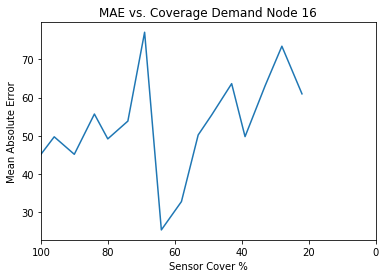

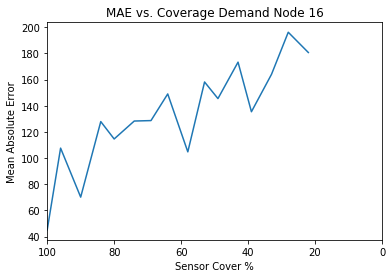

In [6]:
plt.plot(sensors_covered, MAE_average)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Demand Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(sensors_covered, maximum_MAE)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Demand Node 16")
plt.xlim([100, 0])
plt.savefig('/Users/alexellard/Downloads/Demands16MAE.png')
plt.show()

Feature: 0, Score: 0.03261
Feature: 1, Score: 0.00040
Feature: 2, Score: 0.00174
Feature: 3, Score: 0.21683
Feature: 4, Score: 0.00035
Feature: 5, Score: 0.00035
Feature: 6, Score: 0.00025
Feature: 7, Score: 0.00262
Feature: 8, Score: 0.00108
Feature: 9, Score: 0.00132
Feature: 10, Score: 0.01677
Feature: 11, Score: 0.00125
Feature: 12, Score: 0.00121
Feature: 13, Score: 0.10958
Feature: 14, Score: 0.59321
Feature: 15, Score: 0.00529
Feature: 16, Score: 0.00205
Feature: 17, Score: 0.00643
Feature: 18, Score: 0.00560
Feature: 19, Score: 0.00105


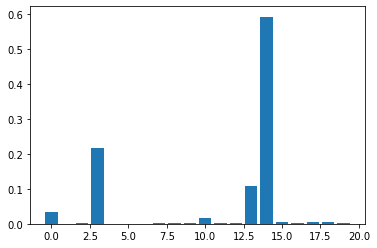

In [8]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [12]:
Y = df[df.columns[16]]
X = df.drop(columns=['node_16_demand'])
X['node_16_demand'] = Y
print('starting df shape:', X.shape)

# split into train and test sets
values = X.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
train, test = train_test_split(scaled, test_size=0.2, random_state=0)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

#define model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)

# fit the model on the training data
model.fit(train_X, train_y)

# make predictions on the test data
y_pred = model.predict(test_X)

test_y = test_y.reshape((len(test_y), 1))
print('test y shape :', test_y.shape)
inv_test_y = concatenate((test_y, test_X[:, -X.shape[1]:]), axis=1)
print('Inv y shape :', inv_test_y.shape)
test_y_inverse = scaler.inverse_transform(inv_test_y)
test_y_inverse = test_y_inverse[:,0]

y_pred = y_pred.reshape((len(y_pred), 1))
print('y pred shape :', y_pred.shape)
inv_y_pred = concatenate((y_pred, test_X[:, -X.shape[1]:]), axis=1)
print('inv y pred :', inv_y_pred.shape)
y_pred_inverse = scaler.inverse_transform(inv_y_pred)
y_pred_inverse = y_pred_inverse[:,0]

# evaluate scaled errors
mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
MAE.append(mae_inverse)
print(f'Run {run} Mean Absolute Error:', mae_inverse)

starting df shape: (87600, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 10 Mean Absolute Error: 45.13374937313199


In [ ]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()